In [26]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import esm


from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.genotypevae.genotypeVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import SCVIZ_CheckNet2Net


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# download Table S1. MORF library and bulk TF screening results, related to Figures 1 and 5
# from paper A transcription factor atlas of directed differentiation
# https://www.cell.com/cms/10.1016/j.cell.2022.11.026/attachment/cbf781f9-487c-43e7-b027-3a024d616978/mmc2.xlsx

In [28]:
!pip install openpyxl

In [29]:
filename = "Datasets/mmc2.xlsx"
df = pd.read_excel(filename)

In [30]:
df

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Unsorted M5,Unsorted M6,Unsorted M7,Sorted M1,Sorted M2,Sorted M3,Sorted M4,Sorted M5,Sorted M6,Sorted M7
0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,0.741477,...,0.753406,0.69928,0.739478,0.583287,1.239247,0.494161,0.608434,0.845344,0.416131,0.806574
1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,1.154538,...,1.230757,1.190904,1.157486,1.148422,0.626313,0.506171,0.614142,1.001454,0.422706,0.653929
2,Genewiz,TFORF0003,HIF3A,"NM_152794,ENST00000300862",HIF3A-3,ACCGCCACCATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGC...,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTCAGACGTTTCGCGCCTGGAGCT,NaN,0.452996,...,0.501922,0.447661,0.448459,2.272697,0.856028,0.733962,0.856931,0.971706,1.202011,1.318766
3,Genewiz,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",HIF3A-4,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,GATAACGCTAACCACAAGGTATTT,NaN,0.737029,...,0.719755,0.742657,0.769745,0.709989,0.968796,0.565647,0.558274,0.637649,0.551871,1.036478
4,Genewiz,TFORF0005,HIF3A,"NM_152795,ENST00000377670",HIF3A-5,ACCGCCACCATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGG...,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,CCACGCGAGCTAGACGATCGATGA,NaN,0.495175,...,0.497902,0.47746,0.502449,0.591106,0.574273,0.918527,0.657411,1.206897,1.035907,0.615581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,Broad GPP,TFORF3546,TSC22D3,NM_001015881.1,TSC22D3-3,ATCGATTGATCAACAAGTTTGTACAAAAAAGTGGGCATGGATCTGG...,ATGGATCTGGTGAAGAATCATCTGATGTATGCTGTGAGAGAGGAGG...,CGCGCGATGTAGTTTTCTGCACTA,V5,0.960177,...,1.040703,0.949108,0.888872,0.973268,0.798689,0.861405,1.096751,0.787985,0.820582,0.762827
3546,Broad GPP,TFORF3547,CBFB,NM_001755.2,CBFB-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGCGCG...,ATGCCGCGCGTCGTGCCCGACCAGAGAAGCAAGTTCGAGAACGAGG...,ACCCGATCCTGGGATTCCCTATCG,V5,0.880038,...,0.836117,0.777777,0.892892,0.948452,0.753905,0.993762,1.008643,0.836588,0.80091,0.689051
3547,Broad GPP,TFORF3548,THAP10,NM_020147.3,THAP10-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGGCCC...,ATGCCGGCCCGTTGTGTGGCCGCCCACTGCGGCAACACCACCAAGT...,CTTCTATCAGCCTATCTCTGGGGC,V5,1.905151,...,1.812144,1.741574,1.852358,0.921356,0.913935,0.790098,1.050126,0.89115,0.625428,0.626536
3548,Neither,TFORF3549,GFP,-,-,ACCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGG...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,GCTGACTCCTTCTTGGGAATCTGC,NaN,-,...,-,-,-,-,-,-,-,-,-,-


In [31]:
df.columns

Index(['Source', 'Name', 'RefSeq Gene Name', 'RefSeq and Gencode ID',
       'Isoform ID', 'Insert', 'ORF sequence', 'Barcode Sequence',
       'Epitope Tag', 'Unsorted M1', 'Unsorted M2', 'Unsorted M3',
       'Unsorted M4', 'Unsorted M5', 'Unsorted M6', 'Unsorted M7', 'Sorted M1',
       'Sorted M2', 'Sorted M3', 'Sorted M4', 'Sorted M5', 'Sorted M6',
       'Sorted M7'],
      dtype='object')

In [32]:
len(df['ORF sequence'])

3550

In [33]:
len(df['ORF sequence'].unique())

3526

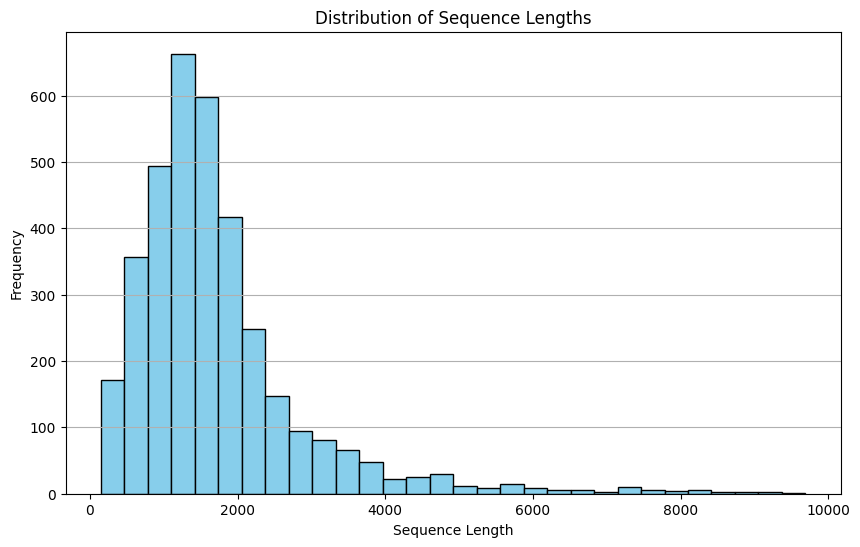

In [34]:
import matplotlib.pyplot as plt

# Calculate the length of each sequence
sequence_lengths = df['ORF sequence'].apply(len)

# Plot the distribution as a histogram
plt.figure(figsize=(10,6))
plt.hist(sequence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.grid(axis='y')
plt.show()

In [35]:
count_less_than_3069 = (df['ORF sequence'].apply(len) < 3069).sum()
print(f"Number of sequences shorter than 3069: {count_less_than_3069}")

Number of sequences shorter than 3069: 3203


In [36]:
filtered_df = df[df['ORF sequence'].apply(len) < 3069]

In [37]:
filtered_df

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Unsorted M5,Unsorted M6,Unsorted M7,Sorted M1,Sorted M2,Sorted M3,Sorted M4,Sorted M5,Sorted M6,Sorted M7
0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,0.741477,...,0.753406,0.69928,0.739478,0.583287,1.239247,0.494161,0.608434,0.845344,0.416131,0.806574
1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,1.154538,...,1.230757,1.190904,1.157486,1.148422,0.626313,0.506171,0.614142,1.001454,0.422706,0.653929
2,Genewiz,TFORF0003,HIF3A,"NM_152794,ENST00000300862",HIF3A-3,ACCGCCACCATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGC...,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTCAGACGTTTCGCGCCTGGAGCT,NaN,0.452996,...,0.501922,0.447661,0.448459,2.272697,0.856028,0.733962,0.856931,0.971706,1.202011,1.318766
3,Genewiz,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",HIF3A-4,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,GATAACGCTAACCACAAGGTATTT,NaN,0.737029,...,0.719755,0.742657,0.769745,0.709989,0.968796,0.565647,0.558274,0.637649,0.551871,1.036478
4,Genewiz,TFORF0005,HIF3A,"NM_152795,ENST00000377670",HIF3A-5,ACCGCCACCATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGG...,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,CCACGCGAGCTAGACGATCGATGA,NaN,0.495175,...,0.497902,0.47746,0.502449,0.591106,0.574273,0.918527,0.657411,1.206897,1.035907,0.615581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,Broad GPP,TFORF3546,TSC22D3,NM_001015881.1,TSC22D3-3,ATCGATTGATCAACAAGTTTGTACAAAAAAGTGGGCATGGATCTGG...,ATGGATCTGGTGAAGAATCATCTGATGTATGCTGTGAGAGAGGAGG...,CGCGCGATGTAGTTTTCTGCACTA,V5,0.960177,...,1.040703,0.949108,0.888872,0.973268,0.798689,0.861405,1.096751,0.787985,0.820582,0.762827
3546,Broad GPP,TFORF3547,CBFB,NM_001755.2,CBFB-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGCGCG...,ATGCCGCGCGTCGTGCCCGACCAGAGAAGCAAGTTCGAGAACGAGG...,ACCCGATCCTGGGATTCCCTATCG,V5,0.880038,...,0.836117,0.777777,0.892892,0.948452,0.753905,0.993762,1.008643,0.836588,0.80091,0.689051
3547,Broad GPP,TFORF3548,THAP10,NM_020147.3,THAP10-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGGCCC...,ATGCCGGCCCGTTGTGTGGCCGCCCACTGCGGCAACACCACCAAGT...,CTTCTATCAGCCTATCTCTGGGGC,V5,1.905151,...,1.812144,1.741574,1.852358,0.921356,0.913935,0.790098,1.050126,0.89115,0.625428,0.626536
3548,Neither,TFORF3549,GFP,-,-,ACCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGG...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,GCTGACTCCTTCTTGGGAATCTGC,NaN,-,...,-,-,-,-,-,-,-,-,-,-


In [38]:
!pip install biopython

In [39]:
import pandas as pd
from Bio.Seq import Seq

# Add protein sequence column
filtered_df['protein_seq'] = filtered_df['ORF sequence'].apply(lambda x: str(Seq(x).translate()))

/var/folders/jl/gnkp_hvs3zqb957750yclnqr0000gn/T/ipykernel_15717/144361937.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['protein_seq'] = filtered_df['ORF sequence'].apply(lambda x: str(Seq(x).translate()))


In [40]:
filtered_df

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Unsorted M6,Unsorted M7,Sorted M1,Sorted M2,Sorted M3,Sorted M4,Sorted M5,Sorted M6,Sorted M7,protein_seq
0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,0.741477,...,0.69928,0.739478,0.583287,1.239247,0.494161,0.608434,0.845344,0.416131,0.806574,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,1.154538,...,1.190904,1.157486,1.148422,0.626313,0.506171,0.614142,1.001454,0.422706,0.653929,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
2,Genewiz,TFORF0003,HIF3A,"NM_152794,ENST00000300862",HIF3A-3,ACCGCCACCATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGC...,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTCAGACGTTTCGCGCCTGGAGCT,NaN,0.452996,...,0.447661,0.448459,2.272697,0.856028,0.733962,0.856931,0.971706,1.202011,1.318766,MDWQDHRSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARGVS...
3,Genewiz,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",HIF3A-4,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,GATAACGCTAACCACAAGGTATTT,NaN,0.737029,...,0.742657,0.769745,0.709989,0.968796,0.565647,0.558274,0.637649,0.551871,1.036478,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
4,Genewiz,TFORF0005,HIF3A,"NM_152795,ENST00000377670",HIF3A-5,ACCGCCACCATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGG...,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,CCACGCGAGCTAGACGATCGATGA,NaN,0.495175,...,0.47746,0.502449,0.591106,0.574273,0.918527,0.657411,1.206897,1.035907,0.615581,MALGLQRARSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,Broad GPP,TFORF3546,TSC22D3,NM_001015881.1,TSC22D3-3,ATCGATTGATCAACAAGTTTGTACAAAAAAGTGGGCATGGATCTGG...,ATGGATCTGGTGAAGAATCATCTGATGTATGCTGTGAGAGAGGAGG...,CGCGCGATGTAGTTTTCTGCACTA,V5,0.960177,...,0.949108,0.888872,0.973268,0.798689,0.861405,1.096751,0.787985,0.820582,0.762827,MDLVKNHLMYAVREEVEILKEQIRELVEKNSQLERENTLLKTLASP...
3546,Broad GPP,TFORF3547,CBFB,NM_001755.2,CBFB-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGCGCG...,ATGCCGCGCGTCGTGCCCGACCAGAGAAGCAAGTTCGAGAACGAGG...,ACCCGATCCTGGGATTCCCTATCG,V5,0.880038,...,0.777777,0.892892,0.948452,0.753905,0.993762,1.008643,0.836588,0.80091,0.689051,MPRVVPDQRSKFENEEFFRKLSRECEIKYTGFRDRPHEERQARFQN...
3547,Broad GPP,TFORF3548,THAP10,NM_020147.3,THAP10-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGGCCC...,ATGCCGGCCCGTTGTGTGGCCGCCCACTGCGGCAACACCACCAAGT...,CTTCTATCAGCCTATCTCTGGGGC,V5,1.905151,...,1.741574,1.852358,0.921356,0.913935,0.790098,1.050126,0.89115,0.625428,0.626536,MPARCVAAHCGNTTKSGKSLFRFPKDRAVRLLWDRFVRGCRADWYG...
3548,Neither,TFORF3549,GFP,-,-,ACCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGG...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,GCTGACTCCTTCTTGGGAATCTGC,NaN,-,...,-,-,-,-,-,-,-,-,-,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...


In [41]:
filtered_df.to_csv("Datasets/morf_less_3069.csv")

# Create embeddings for MORF

In [42]:
# load downloaded ESM model
path_ESM = ""
torch.hub.set_dir(path_ESM)
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S()

/Users/newuser/anaconda3/envs/PerturbNet/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [43]:
filtered_df = pd.read_csv("Datasets/morf_less_3069.csv")

In [44]:
filtered_df

,Unnamed: 0,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,...,Unsorted M6,Unsorted M7,Sorted M1,Sorted M2,Sorted M3,Sorted M4,Sorted M5,Sorted M6,Sorted M7,protein_seq
0,0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,...,0.6992798395,0.739478308,0.5832873715,1.2392466185,0.4941610715,0.6084341470000001,0.845343945,0.41613094749999996,0.8065738665,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
1,1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,...,1.1909042865,1.157485845,1.148422318,0.6263125975,0.5061714795,0.6141420664999999,1.001454306,0.4227059445,0.6539290019999999,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
2,2,Genewiz,TFORF0003,HIF3A,"NM_152794,ENST00000300862",HIF3A-3,ACCGCCACCATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGC...,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTCAGACGTTTCGCGCCTGGAGCT,NaN,...,0.447660996,0.44845887500000003,2.272696743,0.856027864,0.733961733,0.856930972,0.9717059910000001,1.20201072,1.3187659040000002,MDWQDHRSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARGVS...
3,3,Genewiz,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",HIF3A-4,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,GATAACGCTAACCACAAGGTATTT,NaN,...,0.7426571935,0.7697450715,0.7099893875000001,0.968795771,0.565647477,0.558274185,0.6376487495000001,0.551870697,1.0364776455000002,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
4,4,Genewiz,TFORF0005,HIF3A,"NM_152795,ENST00000377670",HIF3A-5,ACCGCCACCATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGG...,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,CCACGCGAGCTAGACGATCGATGA,NaN,...,0.4774604485,0.502449455,0.5911060775,0.5742731415,0.9185268065000001,0.657410973,1.2068972375,1.0359074225,0.6155809015,MALGLQRARSTTELRKEKSRDAARSRRSQETEVLYQLAHTLPFARG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,3545,Broad GPP,TFORF3546,TSC22D3,NM_001015881.1,TSC22D3-3,ATCGATTGATCAACAAGTTTGTACAAAAAAGTGGGCATGGATCTGG...,ATGGATCTGGTGAAGAATCATCTGATGTATGCTGTGAGAGAGGAGG...,CGCGCGATGTAGTTTTCTGCACTA,V5,...,0.9491079635,0.8888717615,0.973267863,0.7986887315,0.8614051785000001,1.096751292,0.7879849155,0.8205817715,0.762827206,MDLVKNHLMYAVREEVEILKEQIRELVEKNSQLERENTLLKTLASP...
3199,3546,Broad GPP,TFORF3547,CBFB,NM_001755.2,CBFB-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGCGCG...,ATGCCGCGCGTCGTGCCCGACCAGAGAAGCAAGTTCGAGAACGAGG...,ACCCGATCCTGGGATTCCCTATCG,V5,...,0.7777765295000001,0.892891796,0.948452354,0.753905467,0.9937623165,1.0086427785,0.8365878285,0.8009095575,0.6890514665,MPRVVPDQRSKFENEEFFRKLSRECEIKYTGFRDRPHEERQARFQN...
3200,3547,Broad GPP,TFORF3548,THAP10,NM_020147.3,THAP10-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGGCCC...,ATGCCGGCCCGTTGTGTGGCCGCCCACTGCGGCAACACCACCAAGT...,CTTCTATCAGCCTATCTCTGGGGC,V5,...,1.7415735615,1.85235841,0.9213558580000001,0.9139347115,0.7900979455,1.0501261165,0.8911501580000001,0.6254279455,0.626536252,MPARCVAAHCGNTTKSGKSLFRFPKDRAVRLLWDRFVRGCRADWYG...
3201,3548,Neither,TFORF3549,GFP,-,-,ACCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGG...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,GCTGACTCCTTCTTGGGAATCTGC,NaN,...,-,-,-,-,-,-,-,-,-,MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLK...


In [45]:
# create embedding for all the sequences in the dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import glob

sequences = filtered_df['protein_seq']
batch_size = 4
output_dir = "embedding_batches"
os.makedirs(output_dir, exist_ok=True)

batch_csv_files = []

# Process batches and save individual CSV files
for i in tqdm(range(0, len(sequences), batch_size)):
    batch_index = i // batch_size + 1
    csv_path = os.path.join(output_dir, f'morf_embeddings_batch_{batch_index}.csv')
    
    # Check if batch file already exists
    if os.path.exists(csv_path):
        print(f"Batch {batch_index} already exists, skipping...")
        batch_csv_files.append(csv_path)
        continue
    
    batch_seqs = list(sequences[i : i + batch_size])
    # print(batch_seqs)
    # print(type(batch_seqs))
    # print(len(batch_seqs))
    
    # Get embeddings for the current batch
    batch_embeddings = Seq_to_Embed_ESM(batch_seqs, batch_size=len(batch_seqs),
                                       model=model, alphabet=alphabet, save_path=None)
    
    batch_embeddings_arr = np.vstack(batch_embeddings)
    
    df_batch = pd.DataFrame(batch_embeddings_arr, columns=[f'emb_dim_{j+1}' for j in range(batch_embeddings_arr.shape[1])])
    df_batch.insert(0, 'sequence', batch_seqs)
    
    # print(df_batch)
    
    df_batch.to_csv(csv_path, index=False)
    print(f"Saved batch {batch_index} to {csv_path}")
    batch_csv_files.append(csv_path)

# Combine all batch CSV files into a single DataFrame
combined_df = pd.concat([pd.read_csv(f) for f in batch_csv_files], ignore_index=True)

# Save combined DataFrame to a single CSV file
combined_csv_path = os.path.join(output_dir, "morf_embeddings_combined.csv")
combined_df.to_csv(combined_csv_path, index=False)
print(f"Saved combined embeddings to {combined_csv_path}")

  0%|                                                                                         | 1/801 [00:26<5:54:48, 26.61s/it]

Saved batch 1 to embedding_batches/morf_embeddings_batch_1.csv



  0%|▏                                                                                        | 2/801 [00:51<5:44:15, 25.85s/it]

Saved batch 2 to embedding_batches/morf_embeddings_batch_2.csv



  0%|▎                                                                                        | 3/801 [01:22<6:13:24, 28.08s/it]

Saved batch 3 to embedding_batches/morf_embeddings_batch_3.csv



  0%|▍                                                                                        | 4/801 [01:38<5:07:57, 23.18s/it]

Saved batch 4 to embedding_batches/morf_embeddings_batch_4.csv



  1%|▌                                                                                        | 5/801 [01:56<4:43:40, 21.38s/it]

Saved batch 5 to embedding_batches/morf_embeddings_batch_5.csv



  1%|▋                                                                                        | 6/801 [02:21<4:59:56, 22.64s/it]

Saved batch 6 to embedding_batches/morf_embeddings_batch_6.csv



  1%|▊                                                                                        | 7/801 [02:55<5:48:33, 26.34s/it]

Saved batch 7 to embedding_batches/morf_embeddings_batch_7.csv



  1%|▉                                                                                        | 8/801 [03:27<6:11:44, 28.13s/it]

Saved batch 8 to embedding_batches/morf_embeddings_batch_8.csv



  1%|█                                                                                        | 9/801 [03:58<6:21:56, 28.94s/it]

Saved batch 9 to embedding_batches/morf_embeddings_batch_9.csv



  1%|█                                                                                       | 10/801 [04:18<5:46:59, 26.32s/it]

Saved batch 10 to embedding_batches/morf_embeddings_batch_10.csv



  1%|█▏                                                                                      | 11/801 [04:38<5:22:17, 24.48s/it]

Saved batch 11 to embedding_batches/morf_embeddings_batch_11.csv



  1%|█▎                                                                                      | 12/801 [04:43<4:01:38, 18.38s/it]

Saved batch 12 to embedding_batches/morf_embeddings_batch_12.csv



  2%|█▍                                                                                      | 13/801 [04:59<3:53:19, 17.77s/it]

Saved batch 13 to embedding_batches/morf_embeddings_batch_13.csv



  2%|█▌                                                                                      | 14/801 [05:20<4:03:27, 18.56s/it]

Saved batch 14 to embedding_batches/morf_embeddings_batch_14.csv



  2%|█▋                                                                                      | 15/801 [06:21<6:51:44, 31.43s/it]

Saved batch 15 to embedding_batches/morf_embeddings_batch_15.csv



  2%|█▊                                                                                      | 16/801 [07:28<9:12:39, 42.24s/it]

Saved batch 16 to embedding_batches/morf_embeddings_batch_16.csv



  2%|█▊                                                                                      | 17/801 [08:03<8:43:21, 40.05s/it]

Saved batch 17 to embedding_batches/morf_embeddings_batch_17.csv



  2%|█▉                                                                                      | 18/801 [08:38<8:20:43, 38.37s/it]

Saved batch 18 to embedding_batches/morf_embeddings_batch_18.csv



  2%|██                                                                                      | 19/801 [08:46<6:20:53, 29.22s/it]

Saved batch 19 to embedding_batches/morf_embeddings_batch_19.csv



  2%|██▏                                                                                     | 20/801 [08:53<4:54:10, 22.60s/it]

Saved batch 20 to embedding_batches/morf_embeddings_batch_20.csv



  3%|██▎                                                                                     | 21/801 [09:20<5:12:57, 24.07s/it]

Saved batch 21 to embedding_batches/morf_embeddings_batch_21.csv



  3%|██▍                                                                                     | 22/801 [09:37<4:44:50, 21.94s/it]

Saved batch 22 to embedding_batches/morf_embeddings_batch_22.csv



  3%|██▌                                                                                     | 23/801 [09:56<4:33:49, 21.12s/it]

Saved batch 23 to embedding_batches/morf_embeddings_batch_23.csv



  3%|██▋                                                                                     | 24/801 [10:10<4:04:17, 18.86s/it]

Saved batch 24 to embedding_batches/morf_embeddings_batch_24.csv



  3%|██▋                                                                                     | 25/801 [10:40<4:45:29, 22.07s/it]

Saved batch 25 to embedding_batches/morf_embeddings_batch_25.csv



  3%|██▊                                                                                     | 26/801 [11:13<5:27:32, 25.36s/it]

Saved batch 26 to embedding_batches/morf_embeddings_batch_26.csv



  3%|██▉                                                                                     | 27/801 [11:37<5:21:50, 24.95s/it]

Saved batch 27 to embedding_batches/morf_embeddings_batch_27.csv



  3%|███                                                                                     | 28/801 [11:53<4:49:21, 22.46s/it]

Saved batch 28 to embedding_batches/morf_embeddings_batch_28.csv



  4%|███▏                                                                                    | 29/801 [12:28<5:37:07, 26.20s/it]

Saved batch 29 to embedding_batches/morf_embeddings_batch_29.csv



  4%|███▎                                                                                    | 30/801 [13:03<6:08:06, 28.65s/it]

Saved batch 30 to embedding_batches/morf_embeddings_batch_30.csv



  4%|███▍                                                                                    | 31/801 [13:11<4:51:35, 22.72s/it]

Saved batch 31 to embedding_batches/morf_embeddings_batch_31.csv



  4%|███▌                                                                                    | 32/801 [13:32<4:42:57, 22.08s/it]

Saved batch 32 to embedding_batches/morf_embeddings_batch_32.csv



  4%|███▋                                                                                    | 33/801 [13:44<4:04:33, 19.11s/it]

Saved batch 33 to embedding_batches/morf_embeddings_batch_33.csv



  4%|███▋                                                                                    | 34/801 [14:27<5:33:45, 26.11s/it]

Saved batch 34 to embedding_batches/morf_embeddings_batch_34.csv



  4%|███▊                                                                                    | 35/801 [14:51<5:27:50, 25.68s/it]

Saved batch 35 to embedding_batches/morf_embeddings_batch_35.csv



  4%|███▉                                                                                    | 36/801 [15:23<5:49:58, 27.45s/it]

Saved batch 36 to embedding_batches/morf_embeddings_batch_36.csv



  5%|████                                                                                    | 37/801 [15:32<4:40:57, 22.07s/it]

Saved batch 37 to embedding_batches/morf_embeddings_batch_37.csv



  5%|████▏                                                                                   | 38/801 [15:53<4:35:09, 21.64s/it]

Saved batch 38 to embedding_batches/morf_embeddings_batch_38.csv



  5%|████▎                                                                                   | 39/801 [16:12<4:22:56, 20.70s/it]

Saved batch 39 to embedding_batches/morf_embeddings_batch_39.csv



  5%|████▍                                                                                   | 40/801 [16:51<5:35:14, 26.43s/it]

Saved batch 40 to embedding_batches/morf_embeddings_batch_40.csv



  5%|████▌                                                                                   | 41/801 [17:02<4:34:39, 21.68s/it]

Saved batch 41 to embedding_batches/morf_embeddings_batch_41.csv



  5%|████▌                                                                                   | 42/801 [17:18<4:11:13, 19.86s/it]

Saved batch 42 to embedding_batches/morf_embeddings_batch_42.csv



  5%|████▋                                                                                   | 43/801 [17:46<4:45:01, 22.56s/it]

Saved batch 43 to embedding_batches/morf_embeddings_batch_43.csv



  5%|████▊                                                                                   | 44/801 [18:47<7:07:06, 33.85s/it]

Saved batch 44 to embedding_batches/morf_embeddings_batch_44.csv



  6%|████▉                                                                                   | 45/801 [19:16<6:49:48, 32.52s/it]

Saved batch 45 to embedding_batches/morf_embeddings_batch_45.csv



  6%|█████                                                                                   | 46/801 [19:30<5:37:22, 26.81s/it]

Saved batch 46 to embedding_batches/morf_embeddings_batch_46.csv



  6%|█████▏                                                                                  | 47/801 [19:58<5:43:48, 27.36s/it]

Saved batch 47 to embedding_batches/morf_embeddings_batch_47.csv



  6%|█████▎                                                                                  | 48/801 [20:24<5:36:59, 26.85s/it]

Saved batch 48 to embedding_batches/morf_embeddings_batch_48.csv



  6%|█████▍                                                                                  | 49/801 [20:50<5:32:27, 26.53s/it]

Saved batch 49 to embedding_batches/morf_embeddings_batch_49.csv



  6%|█████▍                                                                                  | 50/801 [21:15<5:27:14, 26.14s/it]

Saved batch 50 to embedding_batches/morf_embeddings_batch_50.csv



  6%|█████▌                                                                                  | 51/801 [21:48<5:52:37, 28.21s/it]

Saved batch 51 to embedding_batches/morf_embeddings_batch_51.csv



  6%|█████▋                                                                                  | 52/801 [22:11<5:34:37, 26.81s/it]

Saved batch 52 to embedding_batches/morf_embeddings_batch_52.csv



  7%|█████▊                                                                                  | 53/801 [22:27<4:51:23, 23.37s/it]

Saved batch 53 to embedding_batches/morf_embeddings_batch_53.csv



  7%|█████▉                                                                                  | 54/801 [22:54<5:05:00, 24.50s/it]

Saved batch 54 to embedding_batches/morf_embeddings_batch_54.csv



  7%|██████                                                                                  | 55/801 [23:26<5:31:31, 26.66s/it]

Saved batch 55 to embedding_batches/morf_embeddings_batch_55.csv



  7%|██████▏                                                                                 | 56/801 [23:44<4:58:22, 24.03s/it]

Saved batch 56 to embedding_batches/morf_embeddings_batch_56.csv



  7%|██████▎                                                                                 | 57/801 [24:09<5:02:21, 24.38s/it]

Saved batch 57 to embedding_batches/morf_embeddings_batch_57.csv



  7%|██████▎                                                                                 | 58/801 [24:39<5:25:31, 26.29s/it]

Saved batch 58 to embedding_batches/morf_embeddings_batch_58.csv



  7%|██████▍                                                                                 | 59/801 [25:03<5:15:10, 25.49s/it]

Saved batch 59 to embedding_batches/morf_embeddings_batch_59.csv



  7%|██████▌                                                                                 | 60/801 [25:27<5:10:27, 25.14s/it]

Saved batch 60 to embedding_batches/morf_embeddings_batch_60.csv



  8%|██████▋                                                                                 | 61/801 [25:53<5:10:34, 25.18s/it]

Saved batch 61 to embedding_batches/morf_embeddings_batch_61.csv



  8%|██████▊                                                                                 | 62/801 [26:16<5:04:29, 24.72s/it]

Saved batch 62 to embedding_batches/morf_embeddings_batch_62.csv



  8%|██████▉                                                                                 | 63/801 [26:38<4:51:06, 23.67s/it]

Saved batch 63 to embedding_batches/morf_embeddings_batch_63.csv



  8%|███████                                                                                 | 64/801 [26:53<4:21:00, 21.25s/it]

Saved batch 64 to embedding_batches/morf_embeddings_batch_64.csv



  8%|███████▏                                                                                | 65/801 [27:09<4:01:02, 19.65s/it]

Saved batch 65 to embedding_batches/morf_embeddings_batch_65.csv



  8%|███████▎                                                                                | 66/801 [27:26<3:50:07, 18.79s/it]

Saved batch 66 to embedding_batches/morf_embeddings_batch_66.csv



  8%|███████▎                                                                                | 67/801 [27:39<3:29:25, 17.12s/it]

Saved batch 67 to embedding_batches/morf_embeddings_batch_67.csv



  8%|███████▍                                                                                | 68/801 [27:48<2:57:26, 14.52s/it]

Saved batch 68 to embedding_batches/morf_embeddings_batch_68.csv



  9%|███████▌                                                                                | 69/801 [27:55<2:31:48, 12.44s/it]

Saved batch 69 to embedding_batches/morf_embeddings_batch_69.csv



  9%|███████▋                                                                                | 70/801 [28:04<2:18:15, 11.35s/it]

Saved batch 70 to embedding_batches/morf_embeddings_batch_70.csv



  9%|███████▊                                                                                | 71/801 [28:12<2:06:37, 10.41s/it]

Saved batch 71 to embedding_batches/morf_embeddings_batch_71.csv



  9%|███████▉                                                                                | 72/801 [28:35<2:51:25, 14.11s/it]

Saved batch 72 to embedding_batches/morf_embeddings_batch_72.csv



  9%|████████                                                                                | 73/801 [29:22<4:50:23, 23.93s/it]

Saved batch 73 to embedding_batches/morf_embeddings_batch_73.csv



  9%|████████▏                                                                               | 74/801 [29:52<5:13:40, 25.89s/it]

Saved batch 74 to embedding_batches/morf_embeddings_batch_74.csv



  9%|████████▏                                                                               | 75/801 [30:18<5:11:51, 25.77s/it]

Saved batch 75 to embedding_batches/morf_embeddings_batch_75.csv



  9%|████████▎                                                                               | 76/801 [30:33<4:33:55, 22.67s/it]

Saved batch 76 to embedding_batches/morf_embeddings_batch_76.csv



 10%|████████▍                                                                               | 77/801 [30:55<4:32:17, 22.57s/it]

Saved batch 77 to embedding_batches/morf_embeddings_batch_77.csv



 10%|████████▌                                                                               | 78/801 [31:32<5:23:25, 26.84s/it]

Saved batch 78 to embedding_batches/morf_embeddings_batch_78.csv



 10%|████████▍                                                                             | 79/801 [57:45<98:25:22, 490.75s/it]

Saved batch 79 to embedding_batches/morf_embeddings_batch_79.csv



 10%|████████▌                                                                             | 80/801 [58:18<70:45:47, 353.32s/it]

Saved batch 80 to embedding_batches/morf_embeddings_batch_80.csv



 10%|████████▋                                                                             | 81/801 [58:33<50:19:55, 251.66s/it]

Saved batch 81 to embedding_batches/morf_embeddings_batch_81.csv



 10%|████████▊                                                                             | 82/801 [58:46<35:58:48, 180.15s/it]

Saved batch 82 to embedding_batches/morf_embeddings_batch_82.csv



 10%|████████▉                                                                             | 83/801 [58:56<25:44:13, 129.04s/it]

Saved batch 83 to embedding_batches/morf_embeddings_batch_83.csv



 10%|█████████                                                                              | 84/801 [59:24<19:42:23, 98.95s/it]

Saved batch 84 to embedding_batches/morf_embeddings_batch_84.csv



 11%|█████████▏                                                                             | 85/801 [59:50<15:19:15, 77.03s/it]

Saved batch 85 to embedding_batches/morf_embeddings_batch_85.csv



 11%|█████████▏                                                                           | 86/801 [1:00:10<11:53:44, 59.89s/it]

Saved batch 86 to embedding_batches/morf_embeddings_batch_86.csv



 11%|█████████▎                                                                            | 87/801 [1:00:23<9:05:47, 45.86s/it]

Saved batch 87 to embedding_batches/morf_embeddings_batch_87.csv



 11%|█████████▍                                                                            | 88/801 [1:00:49<7:53:15, 39.83s/it]

Saved batch 88 to embedding_batches/morf_embeddings_batch_88.csv



 11%|█████████▌                                                                            | 89/801 [1:01:10<6:46:47, 34.28s/it]

Saved batch 89 to embedding_batches/morf_embeddings_batch_89.csv



 11%|█████████▋                                                                            | 90/801 [1:01:34<6:09:13, 31.16s/it]

Saved batch 90 to embedding_batches/morf_embeddings_batch_90.csv



 11%|█████████▊                                                                            | 91/801 [1:02:06<6:11:27, 31.39s/it]

Saved batch 91 to embedding_batches/morf_embeddings_batch_91.csv



 11%|█████████▉                                                                            | 92/801 [1:02:31<5:47:59, 29.45s/it]

Saved batch 92 to embedding_batches/morf_embeddings_batch_92.csv



 12%|█████████▉                                                                            | 93/801 [1:02:46<4:55:11, 25.02s/it]

Saved batch 93 to embedding_batches/morf_embeddings_batch_93.csv



 12%|██████████                                                                            | 94/801 [1:02:59<4:12:03, 21.39s/it]

Saved batch 94 to embedding_batches/morf_embeddings_batch_94.csv



 12%|██████████▏                                                                           | 95/801 [1:03:25<4:28:29, 22.82s/it]

Saved batch 95 to embedding_batches/morf_embeddings_batch_95.csv



 12%|██████████▎                                                                           | 96/801 [1:03:41<4:04:11, 20.78s/it]

Saved batch 96 to embedding_batches/morf_embeddings_batch_96.csv



 12%|██████████▍                                                                           | 97/801 [1:04:16<4:55:23, 25.18s/it]

Saved batch 97 to embedding_batches/morf_embeddings_batch_97.csv



 12%|██████████▌                                                                           | 98/801 [1:05:20<7:11:10, 36.80s/it]

Saved batch 98 to embedding_batches/morf_embeddings_batch_98.csv



 12%|██████████▋                                                                           | 99/801 [1:05:55<7:04:19, 36.27s/it]

Saved batch 99 to embedding_batches/morf_embeddings_batch_99.csv



 12%|██████████▌                                                                          | 100/801 [1:07:02<8:49:24, 45.31s/it]

Saved batch 100 to embedding_batches/morf_embeddings_batch_100.csv



 13%|██████████▋                                                                          | 101/801 [1:07:20<7:13:16, 37.14s/it]

Saved batch 101 to embedding_batches/morf_embeddings_batch_101.csv



 13%|██████████▊                                                                          | 102/801 [1:07:47<6:37:28, 34.12s/it]

Saved batch 102 to embedding_batches/morf_embeddings_batch_102.csv



 13%|██████████▉                                                                          | 103/801 [1:08:07<5:48:09, 29.93s/it]

Saved batch 103 to embedding_batches/morf_embeddings_batch_103.csv



 13%|███████████                                                                          | 104/801 [1:08:45<6:16:55, 32.45s/it]

Saved batch 104 to embedding_batches/morf_embeddings_batch_104.csv



 13%|███████████▏                                                                         | 105/801 [1:09:19<6:21:11, 32.86s/it]

Saved batch 105 to embedding_batches/morf_embeddings_batch_105.csv



 13%|███████████▏                                                                         | 106/801 [1:09:54<6:26:39, 33.38s/it]

Saved batch 106 to embedding_batches/morf_embeddings_batch_106.csv



 13%|███████████▎                                                                         | 107/801 [1:10:17<5:51:15, 30.37s/it]

Saved batch 107 to embedding_batches/morf_embeddings_batch_107.csv



 13%|███████████▍                                                                         | 108/801 [1:10:37<5:14:29, 27.23s/it]

Saved batch 108 to embedding_batches/morf_embeddings_batch_108.csv



 14%|███████████▌                                                                         | 109/801 [1:10:58<4:54:03, 25.50s/it]

Saved batch 109 to embedding_batches/morf_embeddings_batch_109.csv



 14%|███████████▋                                                                         | 110/801 [1:11:23<4:51:17, 25.29s/it]

Saved batch 110 to embedding_batches/morf_embeddings_batch_110.csv



 14%|███████████▊                                                                         | 111/801 [1:11:55<5:11:44, 27.11s/it]

Saved batch 111 to embedding_batches/morf_embeddings_batch_111.csv



 14%|███████████▉                                                                         | 112/801 [1:12:12<4:38:36, 24.26s/it]

Saved batch 112 to embedding_batches/morf_embeddings_batch_112.csv



 14%|███████████▉                                                                         | 113/801 [1:12:23<3:52:25, 20.27s/it]

Saved batch 113 to embedding_batches/morf_embeddings_batch_113.csv



 14%|████████████                                                                         | 114/801 [1:12:35<3:23:24, 17.76s/it]

Saved batch 114 to embedding_batches/morf_embeddings_batch_114.csv



 14%|████████████▏                                                                        | 115/801 [1:12:45<2:56:21, 15.43s/it]

Saved batch 115 to embedding_batches/morf_embeddings_batch_115.csv



 14%|████████████▎                                                                        | 116/801 [1:13:02<3:03:03, 16.03s/it]

Saved batch 116 to embedding_batches/morf_embeddings_batch_116.csv



 15%|████████████▍                                                                        | 117/801 [1:13:20<3:09:11, 16.60s/it]

Saved batch 117 to embedding_batches/morf_embeddings_batch_117.csv



 15%|████████████▌                                                                        | 118/801 [1:13:35<3:01:59, 15.99s/it]

Saved batch 118 to embedding_batches/morf_embeddings_batch_118.csv



 15%|████████████▋                                                                        | 119/801 [1:14:07<3:56:04, 20.77s/it]

Saved batch 119 to embedding_batches/morf_embeddings_batch_119.csv



 15%|████████████▋                                                                        | 120/801 [1:14:19<3:26:17, 18.17s/it]

Saved batch 120 to embedding_batches/morf_embeddings_batch_120.csv



 15%|████████████▊                                                                        | 121/801 [1:14:46<3:56:26, 20.86s/it]

Saved batch 121 to embedding_batches/morf_embeddings_batch_121.csv



 15%|████████████▉                                                                        | 122/801 [1:15:15<4:21:41, 23.12s/it]

Saved batch 122 to embedding_batches/morf_embeddings_batch_122.csv



 15%|█████████████                                                                        | 123/801 [1:15:46<4:49:47, 25.64s/it]

Saved batch 123 to embedding_batches/morf_embeddings_batch_123.csv



 15%|█████████████▏                                                                       | 124/801 [1:16:08<4:36:45, 24.53s/it]

Saved batch 124 to embedding_batches/morf_embeddings_batch_124.csv



 16%|█████████████▎                                                                       | 125/801 [1:16:59<6:04:12, 32.33s/it]

Saved batch 125 to embedding_batches/morf_embeddings_batch_125.csv



 16%|█████████████▎                                                                       | 126/801 [1:17:10<4:54:09, 26.15s/it]

Saved batch 126 to embedding_batches/morf_embeddings_batch_126.csv



 16%|█████████████▍                                                                       | 127/801 [1:17:42<5:12:07, 27.79s/it]

Saved batch 127 to embedding_batches/morf_embeddings_batch_127.csv



 16%|█████████████▌                                                                       | 128/801 [1:18:17<5:36:49, 30.03s/it]

Saved batch 128 to embedding_batches/morf_embeddings_batch_128.csv



 16%|█████████████▋                                                                       | 129/801 [1:18:36<4:59:46, 26.77s/it]

Saved batch 129 to embedding_batches/morf_embeddings_batch_129.csv



 16%|█████████████▊                                                                       | 130/801 [1:19:01<4:52:40, 26.17s/it]

Saved batch 130 to embedding_batches/morf_embeddings_batch_130.csv



 16%|█████████████▉                                                                       | 131/801 [1:19:19<4:23:08, 23.57s/it]

Saved batch 131 to embedding_batches/morf_embeddings_batch_131.csv



 16%|██████████████                                                                       | 132/801 [1:19:37<4:04:22, 21.92s/it]

Saved batch 132 to embedding_batches/morf_embeddings_batch_132.csv



 17%|██████████████                                                                       | 133/801 [1:19:59<4:04:22, 21.95s/it]

Saved batch 133 to embedding_batches/morf_embeddings_batch_133.csv



 17%|██████████████▏                                                                      | 134/801 [1:20:18<3:53:52, 21.04s/it]

Saved batch 134 to embedding_batches/morf_embeddings_batch_134.csv



 17%|██████████████▎                                                                      | 135/801 [1:20:34<3:36:52, 19.54s/it]

Saved batch 135 to embedding_batches/morf_embeddings_batch_135.csv



 17%|██████████████▍                                                                      | 136/801 [1:21:09<4:30:01, 24.36s/it]

Saved batch 136 to embedding_batches/morf_embeddings_batch_136.csv



 17%|██████████████▌                                                                      | 137/801 [1:21:25<4:01:45, 21.85s/it]

Saved batch 137 to embedding_batches/morf_embeddings_batch_137.csv



 17%|██████████████▋                                                                      | 138/801 [1:21:59<4:41:08, 25.44s/it]

Saved batch 138 to embedding_batches/morf_embeddings_batch_138.csv



 17%|██████████████▊                                                                      | 139/801 [1:22:17<4:17:02, 23.30s/it]

Saved batch 139 to embedding_batches/morf_embeddings_batch_139.csv



 17%|██████████████▊                                                                      | 140/801 [1:22:31<3:45:02, 20.43s/it]

Saved batch 140 to embedding_batches/morf_embeddings_batch_140.csv



 18%|██████████████▉                                                                      | 141/801 [1:22:38<3:01:21, 16.49s/it]

Saved batch 141 to embedding_batches/morf_embeddings_batch_141.csv



 18%|███████████████                                                                      | 142/801 [1:22:49<2:40:27, 14.61s/it]

Saved batch 142 to embedding_batches/morf_embeddings_batch_142.csv



 18%|███████████████▏                                                                     | 143/801 [1:22:58<2:24:01, 13.13s/it]

Saved batch 143 to embedding_batches/morf_embeddings_batch_143.csv



 18%|███████████████▎                                                                     | 144/801 [1:23:09<2:15:08, 12.34s/it]

Saved batch 144 to embedding_batches/morf_embeddings_batch_144.csv



 18%|███████████████▍                                                                     | 145/801 [1:23:57<4:12:08, 23.06s/it]

Saved batch 145 to embedding_batches/morf_embeddings_batch_145.csv



 18%|███████████████▍                                                                     | 146/801 [1:24:17<4:02:09, 22.18s/it]

Saved batch 146 to embedding_batches/morf_embeddings_batch_146.csv



 18%|███████████████▌                                                                     | 147/801 [1:24:39<4:01:09, 22.12s/it]

Saved batch 147 to embedding_batches/morf_embeddings_batch_147.csv



 18%|███████████████▋                                                                     | 148/801 [1:24:58<3:52:02, 21.32s/it]

Saved batch 148 to embedding_batches/morf_embeddings_batch_148.csv



 19%|███████████████▊                                                                     | 149/801 [1:25:26<4:10:55, 23.09s/it]

Saved batch 149 to embedding_batches/morf_embeddings_batch_149.csv



 19%|███████████████▉                                                                     | 150/801 [1:25:40<3:41:30, 20.42s/it]

Saved batch 150 to embedding_batches/morf_embeddings_batch_150.csv



 19%|████████████████                                                                     | 151/801 [1:25:51<3:10:13, 17.56s/it]

Saved batch 151 to embedding_batches/morf_embeddings_batch_151.csv



 19%|████████████████▏                                                                    | 152/801 [1:26:37<4:41:38, 26.04s/it]

Saved batch 152 to embedding_batches/morf_embeddings_batch_152.csv



 19%|████████████████▏                                                                    | 153/801 [1:27:13<5:14:23, 29.11s/it]

Saved batch 153 to embedding_batches/morf_embeddings_batch_153.csv



 19%|████████████████▎                                                                    | 154/801 [1:27:26<4:22:41, 24.36s/it]

Saved batch 154 to embedding_batches/morf_embeddings_batch_154.csv



 19%|████████████████▍                                                                    | 155/801 [1:27:44<4:02:59, 22.57s/it]

Saved batch 155 to embedding_batches/morf_embeddings_batch_155.csv



 19%|████████████████▌                                                                    | 156/801 [1:28:37<5:38:02, 31.45s/it]

Saved batch 156 to embedding_batches/morf_embeddings_batch_156.csv



 20%|████████████████▋                                                                    | 157/801 [1:29:18<6:10:56, 34.56s/it]

Saved batch 157 to embedding_batches/morf_embeddings_batch_157.csv



 20%|████████████████▊                                                                    | 158/801 [1:29:34<5:10:41, 28.99s/it]

Saved batch 158 to embedding_batches/morf_embeddings_batch_158.csv



 20%|████████████████▊                                                                    | 159/801 [1:29:53<4:38:19, 26.01s/it]

Saved batch 159 to embedding_batches/morf_embeddings_batch_159.csv



 20%|████████████████▉                                                                    | 160/801 [1:30:16<4:26:50, 24.98s/it]

Saved batch 160 to embedding_batches/morf_embeddings_batch_160.csv



 20%|█████████████████                                                                    | 161/801 [1:30:41<4:25:10, 24.86s/it]

Saved batch 161 to embedding_batches/morf_embeddings_batch_161.csv



 20%|█████████████████▏                                                                   | 162/801 [1:31:03<4:16:11, 24.06s/it]

Saved batch 162 to embedding_batches/morf_embeddings_batch_162.csv



 20%|█████████████████▎                                                                   | 163/801 [1:31:13<3:31:58, 19.93s/it]

Saved batch 163 to embedding_batches/morf_embeddings_batch_163.csv



 20%|█████████████████▍                                                                   | 164/801 [1:31:36<3:40:26, 20.76s/it]

Saved batch 164 to embedding_batches/morf_embeddings_batch_164.csv



 21%|█████████████████▌                                                                   | 165/801 [1:32:01<3:52:45, 21.96s/it]

Saved batch 165 to embedding_batches/morf_embeddings_batch_165.csv



 21%|█████████████████▌                                                                   | 166/801 [1:32:19<3:41:47, 20.96s/it]

Saved batch 166 to embedding_batches/morf_embeddings_batch_166.csv



 21%|█████████████████▋                                                                   | 167/801 [1:32:40<3:39:25, 20.77s/it]

Saved batch 167 to embedding_batches/morf_embeddings_batch_167.csv



 21%|█████████████████▊                                                                   | 168/801 [1:33:01<3:42:18, 21.07s/it]

Saved batch 168 to embedding_batches/morf_embeddings_batch_168.csv



 21%|█████████████████▉                                                                   | 169/801 [1:33:32<4:12:58, 24.02s/it]

Saved batch 169 to embedding_batches/morf_embeddings_batch_169.csv



 21%|██████████████████                                                                   | 170/801 [1:33:56<4:11:15, 23.89s/it]

Saved batch 170 to embedding_batches/morf_embeddings_batch_170.csv



 21%|██████████████████▏                                                                  | 171/801 [1:34:35<5:00:11, 28.59s/it]

Saved batch 171 to embedding_batches/morf_embeddings_batch_171.csv



 21%|██████████████████▎                                                                  | 172/801 [1:35:00<4:46:00, 27.28s/it]

Saved batch 172 to embedding_batches/morf_embeddings_batch_172.csv



 22%|██████████████████▎                                                                  | 173/801 [1:35:04<3:34:12, 20.47s/it]

Saved batch 173 to embedding_batches/morf_embeddings_batch_173.csv



 22%|██████████████████▍                                                                  | 174/801 [1:35:21<3:21:12, 19.25s/it]

Saved batch 174 to embedding_batches/morf_embeddings_batch_174.csv



 22%|██████████████████▌                                                                  | 175/801 [1:35:35<3:04:31, 17.69s/it]

Saved batch 175 to embedding_batches/morf_embeddings_batch_175.csv



 22%|██████████████████▋                                                                  | 176/801 [1:35:47<2:47:10, 16.05s/it]

Saved batch 176 to embedding_batches/morf_embeddings_batch_176.csv



 22%|██████████████████▊                                                                  | 177/801 [1:35:59<2:34:14, 14.83s/it]

Saved batch 177 to embedding_batches/morf_embeddings_batch_177.csv



 22%|██████████████████▉                                                                  | 178/801 [1:36:09<2:20:06, 13.49s/it]

Saved batch 178 to embedding_batches/morf_embeddings_batch_178.csv



 22%|██████████████████▉                                                                  | 179/801 [1:36:41<3:15:24, 18.85s/it]

Saved batch 179 to embedding_batches/morf_embeddings_batch_179.csv



 22%|███████████████████                                                                  | 180/801 [1:37:06<3:34:22, 20.71s/it]

Saved batch 180 to embedding_batches/morf_embeddings_batch_180.csv



 23%|███████████████████▏                                                                 | 181/801 [1:37:25<3:29:48, 20.30s/it]

Saved batch 181 to embedding_batches/morf_embeddings_batch_181.csv



 23%|███████████████████▎                                                                 | 182/801 [1:37:57<4:04:35, 23.71s/it]

Saved batch 182 to embedding_batches/morf_embeddings_batch_182.csv



 23%|███████████████████▍                                                                 | 183/801 [1:38:20<4:02:53, 23.58s/it]

Saved batch 183 to embedding_batches/morf_embeddings_batch_183.csv



 23%|███████████████████▌                                                                 | 184/801 [1:38:31<3:24:24, 19.88s/it]

Saved batch 184 to embedding_batches/morf_embeddings_batch_184.csv



 23%|███████████████████▋                                                                 | 185/801 [1:38:56<3:39:35, 21.39s/it]

Saved batch 185 to embedding_batches/morf_embeddings_batch_185.csv



 23%|███████████████████▋                                                                 | 186/801 [1:39:04<2:57:27, 17.31s/it]

Saved batch 186 to embedding_batches/morf_embeddings_batch_186.csv



 23%|███████████████████▊                                                                 | 187/801 [1:39:20<2:52:59, 16.90s/it]

Saved batch 187 to embedding_batches/morf_embeddings_batch_187.csv



 23%|███████████████████▉                                                                 | 188/801 [1:40:34<5:49:27, 34.20s/it]

Saved batch 188 to embedding_batches/morf_embeddings_batch_188.csv



 24%|████████████████████                                                                 | 189/801 [1:40:50<4:52:06, 28.64s/it]

Saved batch 189 to embedding_batches/morf_embeddings_batch_189.csv



 24%|████████████████████▏                                                                | 190/801 [1:41:00<3:54:00, 22.98s/it]

Saved batch 190 to embedding_batches/morf_embeddings_batch_190.csv



 24%|████████████████████▎                                                                | 191/801 [1:41:10<3:15:06, 19.19s/it]

Saved batch 191 to embedding_batches/morf_embeddings_batch_191.csv



 24%|████████████████████▎                                                                | 192/801 [1:41:23<2:56:27, 17.38s/it]

Saved batch 192 to embedding_batches/morf_embeddings_batch_192.csv



 24%|████████████████████▍                                                                | 193/801 [1:41:38<2:48:02, 16.58s/it]

Saved batch 193 to embedding_batches/morf_embeddings_batch_193.csv



 24%|████████████████████▌                                                                | 194/801 [1:41:59<3:00:33, 17.85s/it]

Saved batch 194 to embedding_batches/morf_embeddings_batch_194.csv



 24%|████████████████████▋                                                                | 195/801 [1:42:06<2:26:52, 14.54s/it]

Saved batch 195 to embedding_batches/morf_embeddings_batch_195.csv



 24%|████████████████████▊                                                                | 196/801 [1:42:21<2:29:52, 14.86s/it]

Saved batch 196 to embedding_batches/morf_embeddings_batch_196.csv



 25%|████████████████████▉                                                                | 197/801 [1:42:41<2:43:06, 16.20s/it]

Saved batch 197 to embedding_batches/morf_embeddings_batch_197.csv



 25%|█████████████████████                                                                | 198/801 [1:43:10<3:23:13, 20.22s/it]

Saved batch 198 to embedding_batches/morf_embeddings_batch_198.csv



 25%|█████████████████████                                                                | 199/801 [1:43:57<4:41:42, 28.08s/it]

Saved batch 199 to embedding_batches/morf_embeddings_batch_199.csv



 25%|█████████████████████▏                                                               | 200/801 [1:44:45<5:42:59, 34.24s/it]

Saved batch 200 to embedding_batches/morf_embeddings_batch_200.csv



 25%|█████████████████████▎                                                               | 201/801 [1:44:58<4:38:04, 27.81s/it]

Saved batch 201 to embedding_batches/morf_embeddings_batch_201.csv



 25%|█████████████████████▍                                                               | 202/801 [1:45:15<4:05:48, 24.62s/it]

Saved batch 202 to embedding_batches/morf_embeddings_batch_202.csv



 25%|█████████████████████▌                                                               | 203/801 [1:45:44<4:17:15, 25.81s/it]

Saved batch 203 to embedding_batches/morf_embeddings_batch_203.csv



 25%|█████████████████████▋                                                               | 204/801 [1:46:20<4:48:36, 29.01s/it]

Saved batch 204 to embedding_batches/morf_embeddings_batch_204.csv



 26%|█████████████████████▊                                                               | 205/801 [1:46:36<4:09:22, 25.10s/it]

Saved batch 205 to embedding_batches/morf_embeddings_batch_205.csv



 26%|█████████████████████▊                                                               | 206/801 [1:46:41<3:06:55, 18.85s/it]

Saved batch 206 to embedding_batches/morf_embeddings_batch_206.csv



 26%|█████████████████████▉                                                               | 207/801 [1:46:49<2:34:34, 15.61s/it]

Saved batch 207 to embedding_batches/morf_embeddings_batch_207.csv



 26%|██████████████████████                                                               | 208/801 [1:47:09<2:49:45, 17.18s/it]

Saved batch 208 to embedding_batches/morf_embeddings_batch_208.csv



 26%|██████████████████████▏                                                              | 209/801 [1:47:25<2:44:46, 16.70s/it]

Saved batch 209 to embedding_batches/morf_embeddings_batch_209.csv



 26%|██████████████████████▎                                                              | 210/801 [1:47:56<3:27:04, 21.02s/it]

Saved batch 210 to embedding_batches/morf_embeddings_batch_210.csv



 26%|██████████████████████▍                                                              | 211/801 [1:48:04<2:48:10, 17.10s/it]

Saved batch 211 to embedding_batches/morf_embeddings_batch_211.csv



 26%|██████████████████████▍                                                              | 212/801 [1:48:14<2:28:16, 15.10s/it]

Saved batch 212 to embedding_batches/morf_embeddings_batch_212.csv



 27%|██████████████████████▌                                                              | 213/801 [1:48:26<2:17:49, 14.06s/it]

Saved batch 213 to embedding_batches/morf_embeddings_batch_213.csv



 27%|██████████████████████▋                                                              | 214/801 [1:48:41<2:19:05, 14.22s/it]

Saved batch 214 to embedding_batches/morf_embeddings_batch_214.csv



 27%|██████████████████████▊                                                              | 215/801 [1:49:08<2:57:58, 18.22s/it]

Saved batch 215 to embedding_batches/morf_embeddings_batch_215.csv



 27%|██████████████████████▉                                                              | 216/801 [1:49:19<2:35:46, 15.98s/it]

Saved batch 216 to embedding_batches/morf_embeddings_batch_216.csv



 27%|███████████████████████                                                              | 217/801 [1:49:46<3:06:33, 19.17s/it]

Saved batch 217 to embedding_batches/morf_embeddings_batch_217.csv



 27%|███████████████████████▏                                                             | 218/801 [1:50:08<3:14:55, 20.06s/it]

Saved batch 218 to embedding_batches/morf_embeddings_batch_218.csv



 27%|███████████████████████▏                                                             | 219/801 [1:50:30<3:19:55, 20.61s/it]

Saved batch 219 to embedding_batches/morf_embeddings_batch_219.csv



 27%|███████████████████████▎                                                             | 220/801 [1:50:55<3:34:13, 22.12s/it]

Saved batch 220 to embedding_batches/morf_embeddings_batch_220.csv



 28%|███████████████████████▍                                                             | 221/801 [1:51:30<4:10:11, 25.88s/it]

Saved batch 221 to embedding_batches/morf_embeddings_batch_221.csv



 28%|███████████████████████▌                                                             | 222/801 [1:51:56<4:11:36, 26.07s/it]

Saved batch 222 to embedding_batches/morf_embeddings_batch_222.csv



 28%|███████████████████████▋                                                             | 223/801 [1:52:34<4:45:32, 29.64s/it]

Saved batch 223 to embedding_batches/morf_embeddings_batch_223.csv



 28%|███████████████████████▊                                                             | 224/801 [1:53:01<4:36:50, 28.79s/it]

Saved batch 224 to embedding_batches/morf_embeddings_batch_224.csv



 28%|███████████████████████▉                                                             | 225/801 [1:53:17<3:58:43, 24.87s/it]

Saved batch 225 to embedding_batches/morf_embeddings_batch_225.csv



 28%|███████████████████████▉                                                             | 226/801 [1:53:31<3:26:17, 21.53s/it]

Saved batch 226 to embedding_batches/morf_embeddings_batch_226.csv



 28%|████████████████████████                                                             | 227/801 [1:53:48<3:14:37, 20.34s/it]

Saved batch 227 to embedding_batches/morf_embeddings_batch_227.csv



 28%|████████████████████████▏                                                            | 228/801 [1:54:08<3:12:47, 20.19s/it]

Saved batch 228 to embedding_batches/morf_embeddings_batch_228.csv



 29%|████████████████████████▎                                                            | 229/801 [1:54:39<3:43:34, 23.45s/it]

Saved batch 229 to embedding_batches/morf_embeddings_batch_229.csv



 29%|████████████████████████▍                                                            | 230/801 [1:55:03<3:45:15, 23.67s/it]

Saved batch 230 to embedding_batches/morf_embeddings_batch_230.csv



 29%|████████████████████████▌                                                            | 231/801 [1:55:27<3:43:36, 23.54s/it]

Saved batch 231 to embedding_batches/morf_embeddings_batch_231.csv



 29%|████████████████████████▌                                                            | 232/801 [1:56:01<4:14:58, 26.89s/it]

Saved batch 232 to embedding_batches/morf_embeddings_batch_232.csv



 29%|████████████████████████▋                                                            | 233/801 [1:56:50<5:17:08, 33.50s/it]

Saved batch 233 to embedding_batches/morf_embeddings_batch_233.csv



 29%|████████████████████████▊                                                            | 234/801 [1:57:37<5:53:15, 37.38s/it]

Saved batch 234 to embedding_batches/morf_embeddings_batch_234.csv



 29%|████████████████████████▎                                                          | 235/801 [2:09:40<38:12:58, 243.07s/it]

Saved batch 235 to embedding_batches/morf_embeddings_batch_235.csv



 29%|████████████████████████▍                                                          | 236/801 [2:28:46<80:41:02, 514.09s/it]

Saved batch 236 to embedding_batches/morf_embeddings_batch_236.csv



 30%|████████████████████████▌                                                          | 237/801 [2:29:53<59:31:34, 379.96s/it]

Saved batch 237 to embedding_batches/morf_embeddings_batch_237.csv



 30%|████████████████████████▎                                                         | 238/801 [3:05:09<140:52:23, 900.79s/it]

Saved batch 238 to embedding_batches/morf_embeddings_batch_238.csv



 30%|████████████████████████▊                                                          | 239/801 [3:05:41<99:54:34, 639.99s/it]

Saved batch 239 to embedding_batches/morf_embeddings_batch_239.csv



 30%|████████████████████████▌                                                         | 240/801 [3:22:29<116:58:14, 750.61s/it]

Saved batch 240 to embedding_batches/morf_embeddings_batch_240.csv



 30%|████████████████████████▉                                                          | 241/801 [3:22:54<82:52:46, 532.80s/it]

Saved batch 241 to embedding_batches/morf_embeddings_batch_241.csv



 30%|████████████████████████▍                                                        | 242/801 [5:12:01<362:53:21, 2337.03s/it]

Saved batch 242 to embedding_batches/morf_embeddings_batch_242.csv



 30%|████████████████████████▌                                                        | 243/801 [5:57:47<381:17:02, 2459.90s/it]

Saved batch 243 to embedding_batches/morf_embeddings_batch_243.csv



 30%|████████████████████████▋                                                        | 244/801 [5:58:32<268:29:14, 1735.29s/it]

Saved batch 244 to embedding_batches/morf_embeddings_batch_244.csv



 31%|████████████████████████▊                                                        | 245/801 [5:58:52<188:32:49, 1220.81s/it]

Saved batch 245 to embedding_batches/morf_embeddings_batch_245.csv



 31%|█████████████████████████▏                                                        | 246/801 [5:59:20<133:02:10, 862.94s/it]

Saved batch 246 to embedding_batches/morf_embeddings_batch_246.csv



 31%|█████████████████████████▌                                                         | 247/801 [6:00:04<94:58:02, 617.12s/it]

Saved batch 247 to embedding_batches/morf_embeddings_batch_247.csv



 31%|█████████████████████████▋                                                         | 248/801 [6:00:17<66:57:53, 435.94s/it]

Saved batch 248 to embedding_batches/morf_embeddings_batch_248.csv



 31%|█████████████████████████▊                                                         | 249/801 [6:01:28<50:04:19, 326.56s/it]

Saved batch 249 to embedding_batches/morf_embeddings_batch_249.csv



 31%|█████████████████████████▉                                                         | 250/801 [6:02:01<36:30:40, 238.55s/it]

Saved batch 250 to embedding_batches/morf_embeddings_batch_250.csv



 31%|██████████████████████████                                                         | 251/801 [6:02:32<26:55:06, 176.19s/it]

Saved batch 251 to embedding_batches/morf_embeddings_batch_251.csv



 31%|██████████████████████████                                                         | 252/801 [6:02:46<19:26:19, 127.47s/it]

Saved batch 252 to embedding_batches/morf_embeddings_batch_252.csv



 32%|██████████████████████████▌                                                         | 253/801 [6:02:59<14:11:35, 93.24s/it]

Saved batch 253 to embedding_batches/morf_embeddings_batch_253.csv



 32%|██████████████████████████▋                                                         | 254/801 [6:03:53<12:21:21, 81.32s/it]

Saved batch 254 to embedding_batches/morf_embeddings_batch_254.csv



 32%|██████████████████████████▋                                                         | 255/801 [6:04:51<11:16:58, 74.39s/it]

Saved batch 255 to embedding_batches/morf_embeddings_batch_255.csv



 32%|███████████████████████████▏                                                         | 256/801 [6:05:17<9:02:50, 59.76s/it]

Saved batch 256 to embedding_batches/morf_embeddings_batch_256.csv



 32%|███████████████████████████▎                                                         | 257/801 [6:06:01<8:20:00, 55.15s/it]

Saved batch 257 to embedding_batches/morf_embeddings_batch_257.csv



 32%|███████████████████████████▍                                                         | 258/801 [6:06:23<6:48:52, 45.18s/it]

Saved batch 258 to embedding_batches/morf_embeddings_batch_258.csv



 32%|███████████████████████████▍                                                         | 259/801 [6:06:39<5:29:01, 36.42s/it]

Saved batch 259 to embedding_batches/morf_embeddings_batch_259.csv



 32%|███████████████████████████▌                                                         | 260/801 [6:07:01<4:50:32, 32.22s/it]

Saved batch 260 to embedding_batches/morf_embeddings_batch_260.csv



 33%|███████████████████████████▋                                                         | 261/801 [6:07:24<4:25:11, 29.47s/it]

Saved batch 261 to embedding_batches/morf_embeddings_batch_261.csv



 33%|███████████████████████████▊                                                         | 262/801 [6:07:45<4:00:21, 26.76s/it]

Saved batch 262 to embedding_batches/morf_embeddings_batch_262.csv



 33%|███████████████████████████▉                                                         | 263/801 [6:08:09<3:53:13, 26.01s/it]

Saved batch 263 to embedding_batches/morf_embeddings_batch_263.csv



 33%|████████████████████████████                                                         | 264/801 [6:09:05<5:13:38, 35.04s/it]

Saved batch 264 to embedding_batches/morf_embeddings_batch_264.csv



 33%|████████████████████████████                                                         | 265/801 [6:09:25<4:32:14, 30.48s/it]

Saved batch 265 to embedding_batches/morf_embeddings_batch_265.csv



 33%|████████████████████████████▏                                                        | 266/801 [6:09:53<4:23:53, 29.60s/it]

Saved batch 266 to embedding_batches/morf_embeddings_batch_266.csv



 33%|████████████████████████████▎                                                        | 267/801 [6:10:16<4:05:51, 27.63s/it]

Saved batch 267 to embedding_batches/morf_embeddings_batch_267.csv



 33%|████████████████████████████▍                                                        | 268/801 [6:10:31<3:32:06, 23.88s/it]

Saved batch 268 to embedding_batches/morf_embeddings_batch_268.csv



 34%|████████████████████████████▌                                                        | 269/801 [6:10:38<2:46:08, 18.74s/it]

Saved batch 269 to embedding_batches/morf_embeddings_batch_269.csv



 34%|████████████████████████████▋                                                        | 270/801 [6:11:06<3:12:44, 21.78s/it]

Saved batch 270 to embedding_batches/morf_embeddings_batch_270.csv



 34%|████████████████████████████▊                                                        | 271/801 [6:11:41<3:45:48, 25.56s/it]

Saved batch 271 to embedding_batches/morf_embeddings_batch_271.csv



 34%|████████████████████████████▊                                                        | 272/801 [6:12:36<5:04:10, 34.50s/it]

Saved batch 272 to embedding_batches/morf_embeddings_batch_272.csv



 34%|████████████████████████████▉                                                        | 273/801 [6:13:36<6:10:02, 42.05s/it]

Saved batch 273 to embedding_batches/morf_embeddings_batch_273.csv



 34%|█████████████████████████████                                                        | 274/801 [6:14:00<5:21:05, 36.56s/it]

Saved batch 274 to embedding_batches/morf_embeddings_batch_274.csv



 34%|█████████████████████████████▏                                                       | 275/801 [6:14:25<4:50:36, 33.15s/it]

Saved batch 275 to embedding_batches/morf_embeddings_batch_275.csv



 34%|█████████████████████████████▎                                                       | 276/801 [6:14:35<3:50:27, 26.34s/it]

Saved batch 276 to embedding_batches/morf_embeddings_batch_276.csv



 35%|█████████████████████████████▍                                                       | 277/801 [6:14:47<3:13:11, 22.12s/it]

Saved batch 277 to embedding_batches/morf_embeddings_batch_277.csv



 35%|█████████████████████████████▌                                                       | 278/801 [6:14:59<2:44:42, 18.90s/it]

Saved batch 278 to embedding_batches/morf_embeddings_batch_278.csv



 35%|█████████████████████████████▌                                                       | 279/801 [6:15:24<3:00:58, 20.80s/it]

Saved batch 279 to embedding_batches/morf_embeddings_batch_279.csv



 35%|█████████████████████████████▋                                                       | 280/801 [6:16:28<4:53:24, 33.79s/it]

Saved batch 280 to embedding_batches/morf_embeddings_batch_280.csv



 35%|█████████████████████████████▊                                                       | 281/801 [6:16:49<4:18:31, 29.83s/it]

Saved batch 281 to embedding_batches/morf_embeddings_batch_281.csv



 35%|█████████████████████████████▉                                                       | 282/801 [6:17:10<3:56:48, 27.38s/it]

Saved batch 282 to embedding_batches/morf_embeddings_batch_282.csv



 35%|██████████████████████████████                                                       | 283/801 [6:18:14<5:29:53, 38.21s/it]

Saved batch 283 to embedding_batches/morf_embeddings_batch_283.csv



 35%|██████████████████████████████▏                                                      | 284/801 [6:18:35<4:44:11, 32.98s/it]

Saved batch 284 to embedding_batches/morf_embeddings_batch_284.csv



 36%|██████████████████████████████▏                                                      | 285/801 [6:18:59<4:21:24, 30.40s/it]

Saved batch 285 to embedding_batches/morf_embeddings_batch_285.csv



 36%|██████████████████████████████▎                                                      | 286/801 [6:19:25<4:09:00, 29.01s/it]

Saved batch 286 to embedding_batches/morf_embeddings_batch_286.csv



 36%|██████████████████████████████▍                                                      | 287/801 [6:20:11<4:52:30, 34.14s/it]

Saved batch 287 to embedding_batches/morf_embeddings_batch_287.csv



 36%|██████████████████████████████▌                                                      | 288/801 [6:20:52<5:09:58, 36.25s/it]

Saved batch 288 to embedding_batches/morf_embeddings_batch_288.csv



 36%|██████████████████████████████▋                                                      | 289/801 [6:21:14<4:33:11, 32.01s/it]

Saved batch 289 to embedding_batches/morf_embeddings_batch_289.csv



 36%|██████████████████████████████▊                                                      | 290/801 [6:21:31<3:54:39, 27.55s/it]

Saved batch 290 to embedding_batches/morf_embeddings_batch_290.csv



 36%|██████████████████████████████▉                                                      | 291/801 [6:21:47<3:23:52, 23.99s/it]

Saved batch 291 to embedding_batches/morf_embeddings_batch_291.csv



 36%|██████████████████████████████▉                                                      | 292/801 [6:22:01<2:57:22, 20.91s/it]

Saved batch 292 to embedding_batches/morf_embeddings_batch_292.csv



 37%|███████████████████████████████                                                      | 293/801 [6:22:15<2:40:48, 18.99s/it]

Saved batch 293 to embedding_batches/morf_embeddings_batch_293.csv



 37%|███████████████████████████████▏                                                     | 294/801 [6:22:35<2:42:48, 19.27s/it]

Saved batch 294 to embedding_batches/morf_embeddings_batch_294.csv



 37%|███████████████████████████████▎                                                     | 295/801 [6:22:57<2:49:59, 20.16s/it]

Saved batch 295 to embedding_batches/morf_embeddings_batch_295.csv



 37%|███████████████████████████████▍                                                     | 296/801 [6:23:19<2:53:18, 20.59s/it]

Saved batch 296 to embedding_batches/morf_embeddings_batch_296.csv



 37%|███████████████████████████████▌                                                     | 297/801 [6:24:00<3:43:21, 26.59s/it]

Saved batch 297 to embedding_batches/morf_embeddings_batch_297.csv



 37%|███████████████████████████████▌                                                     | 298/801 [6:24:36<4:08:20, 29.62s/it]

Saved batch 298 to embedding_batches/morf_embeddings_batch_298.csv



 37%|███████████████████████████████▋                                                     | 299/801 [6:25:13<4:26:33, 31.86s/it]

Saved batch 299 to embedding_batches/morf_embeddings_batch_299.csv



 37%|███████████████████████████████▊                                                     | 300/801 [6:25:29<3:44:16, 26.86s/it]

Saved batch 300 to embedding_batches/morf_embeddings_batch_300.csv



 38%|███████████████████████████████▉                                                     | 301/801 [6:25:52<3:34:14, 25.71s/it]

Saved batch 301 to embedding_batches/morf_embeddings_batch_301.csv



 38%|████████████████████████████████                                                     | 302/801 [6:26:23<3:47:51, 27.40s/it]

Saved batch 302 to embedding_batches/morf_embeddings_batch_302.csv



 38%|████████████████████████████████▏                                                    | 303/801 [6:26:36<3:12:24, 23.18s/it]

Saved batch 303 to embedding_batches/morf_embeddings_batch_303.csv



 38%|████████████████████████████████▎                                                    | 304/801 [6:27:07<3:29:29, 25.29s/it]

Saved batch 304 to embedding_batches/morf_embeddings_batch_304.csv



 38%|████████████████████████████████▎                                                    | 305/801 [6:27:54<4:23:39, 31.89s/it]

Saved batch 305 to embedding_batches/morf_embeddings_batch_305.csv



 38%|████████████████████████████████▍                                                    | 306/801 [6:28:19<4:06:27, 29.87s/it]

Saved batch 306 to embedding_batches/morf_embeddings_batch_306.csv



 38%|████████████████████████████████▌                                                    | 307/801 [6:28:42<3:50:13, 27.96s/it]

Saved batch 307 to embedding_batches/morf_embeddings_batch_307.csv



 38%|████████████████████████████████▋                                                    | 308/801 [6:29:06<3:39:53, 26.76s/it]

Saved batch 308 to embedding_batches/morf_embeddings_batch_308.csv



 39%|████████████████████████████████▊                                                    | 309/801 [6:29:27<3:25:03, 25.01s/it]

Saved batch 309 to embedding_batches/morf_embeddings_batch_309.csv



 39%|████████████████████████████████▉                                                    | 310/801 [6:29:41<2:56:04, 21.52s/it]

Saved batch 310 to embedding_batches/morf_embeddings_batch_310.csv



 39%|█████████████████████████████████                                                    | 311/801 [6:30:12<3:19:39, 24.45s/it]

Saved batch 311 to embedding_batches/morf_embeddings_batch_311.csv



 39%|█████████████████████████████████                                                    | 312/801 [6:30:33<3:10:36, 23.39s/it]

Saved batch 312 to embedding_batches/morf_embeddings_batch_312.csv



 39%|█████████████████████████████████▏                                                   | 313/801 [6:30:56<3:08:12, 23.14s/it]

Saved batch 313 to embedding_batches/morf_embeddings_batch_313.csv



 39%|█████████████████████████████████▎                                                   | 314/801 [6:31:55<4:37:14, 34.16s/it]

Saved batch 314 to embedding_batches/morf_embeddings_batch_314.csv



 39%|█████████████████████████████████▍                                                   | 315/801 [6:32:26<4:27:28, 33.02s/it]

Saved batch 315 to embedding_batches/morf_embeddings_batch_315.csv



 39%|█████████████████████████████████▌                                                   | 316/801 [6:32:52<4:11:12, 31.08s/it]

Saved batch 316 to embedding_batches/morf_embeddings_batch_316.csv



 40%|█████████████████████████████████▋                                                   | 317/801 [6:33:11<3:40:07, 27.29s/it]

Saved batch 317 to embedding_batches/morf_embeddings_batch_317.csv



 40%|█████████████████████████████████▋                                                   | 318/801 [6:33:29<3:18:51, 24.70s/it]

Saved batch 318 to embedding_batches/morf_embeddings_batch_318.csv



 40%|█████████████████████████████████▊                                                   | 319/801 [6:33:39<2:43:03, 20.30s/it]

Saved batch 319 to embedding_batches/morf_embeddings_batch_319.csv



 40%|█████████████████████████████████▉                                                   | 320/801 [6:33:55<2:31:49, 18.94s/it]

Saved batch 320 to embedding_batches/morf_embeddings_batch_320.csv



 40%|██████████████████████████████████                                                   | 321/801 [6:34:29<3:07:46, 23.47s/it]

Saved batch 321 to embedding_batches/morf_embeddings_batch_321.csv



 40%|██████████████████████████████████▏                                                  | 322/801 [6:35:06<3:39:42, 27.52s/it]

Saved batch 322 to embedding_batches/morf_embeddings_batch_322.csv



 40%|██████████████████████████████████▎                                                  | 323/801 [6:35:27<3:24:21, 25.65s/it]

Saved batch 323 to embedding_batches/morf_embeddings_batch_323.csv



 40%|██████████████████████████████████▍                                                  | 324/801 [6:35:57<3:32:37, 26.74s/it]

Saved batch 324 to embedding_batches/morf_embeddings_batch_324.csv



 41%|██████████████████████████████████▍                                                  | 325/801 [6:36:17<3:17:31, 24.90s/it]

Saved batch 325 to embedding_batches/morf_embeddings_batch_325.csv



 41%|██████████████████████████████████▌                                                  | 326/801 [6:36:36<3:02:59, 23.11s/it]

Saved batch 326 to embedding_batches/morf_embeddings_batch_326.csv



 41%|██████████████████████████████████▋                                                  | 327/801 [6:37:01<3:06:25, 23.60s/it]

Saved batch 327 to embedding_batches/morf_embeddings_batch_327.csv



 41%|██████████████████████████████████▊                                                  | 328/801 [6:37:19<2:52:22, 21.87s/it]

Saved batch 328 to embedding_batches/morf_embeddings_batch_328.csv



 41%|██████████████████████████████████▉                                                  | 329/801 [6:37:34<2:37:15, 19.99s/it]

Saved batch 329 to embedding_batches/morf_embeddings_batch_329.csv



 41%|███████████████████████████████████                                                  | 330/801 [6:38:32<4:06:05, 31.35s/it]

Saved batch 330 to embedding_batches/morf_embeddings_batch_330.csv



 41%|███████████████████████████████████                                                  | 331/801 [6:38:44<3:19:35, 25.48s/it]

Saved batch 331 to embedding_batches/morf_embeddings_batch_331.csv



 41%|███████████████████████████████████▏                                                 | 332/801 [6:39:16<3:33:31, 27.32s/it]

Saved batch 332 to embedding_batches/morf_embeddings_batch_332.csv



 42%|███████████████████████████████████▎                                                 | 333/801 [6:39:45<3:38:45, 28.05s/it]

Saved batch 333 to embedding_batches/morf_embeddings_batch_333.csv



 42%|███████████████████████████████████▍                                                 | 334/801 [6:40:04<3:14:53, 25.04s/it]

Saved batch 334 to embedding_batches/morf_embeddings_batch_334.csv



 42%|███████████████████████████████████▌                                                 | 335/801 [6:40:16<2:45:51, 21.35s/it]

Saved batch 335 to embedding_batches/morf_embeddings_batch_335.csv



 42%|███████████████████████████████████▋                                                 | 336/801 [6:40:29<2:25:45, 18.81s/it]

Saved batch 336 to embedding_batches/morf_embeddings_batch_336.csv



 42%|███████████████████████████████████▊                                                 | 337/801 [6:41:15<3:28:10, 26.92s/it]

Saved batch 337 to embedding_batches/morf_embeddings_batch_337.csv



 42%|███████████████████████████████████▊                                                 | 338/801 [6:41:37<3:17:01, 25.53s/it]

Saved batch 338 to embedding_batches/morf_embeddings_batch_338.csv



 42%|███████████████████████████████████▉                                                 | 339/801 [6:42:08<3:28:13, 27.04s/it]

Saved batch 339 to embedding_batches/morf_embeddings_batch_339.csv



 42%|████████████████████████████████████                                                 | 340/801 [6:42:41<3:42:44, 28.99s/it]

Saved batch 340 to embedding_batches/morf_embeddings_batch_340.csv



 43%|████████████████████████████████████▏                                                | 341/801 [6:43:04<3:28:34, 27.21s/it]

Saved batch 341 to embedding_batches/morf_embeddings_batch_341.csv



 43%|████████████████████████████████████▎                                                | 342/801 [6:43:31<3:26:25, 26.98s/it]

Saved batch 342 to embedding_batches/morf_embeddings_batch_342.csv



 43%|████████████████████████████████████▍                                                | 343/801 [6:43:58<3:26:32, 27.06s/it]

Saved batch 343 to embedding_batches/morf_embeddings_batch_343.csv



 43%|████████████████████████████████████▌                                                | 344/801 [6:44:06<2:42:12, 21.30s/it]

Saved batch 344 to embedding_batches/morf_embeddings_batch_344.csv



 43%|████████████████████████████████████▌                                                | 345/801 [6:44:23<2:32:44, 20.10s/it]

Saved batch 345 to embedding_batches/morf_embeddings_batch_345.csv



 43%|████████████████████████████████████▋                                                | 346/801 [6:44:42<2:28:14, 19.55s/it]

Saved batch 346 to embedding_batches/morf_embeddings_batch_346.csv



 43%|████████████████████████████████████▊                                                | 347/801 [6:45:06<2:38:20, 20.93s/it]

Saved batch 347 to embedding_batches/morf_embeddings_batch_347.csv



 43%|████████████████████████████████████▉                                                | 348/801 [6:45:42<3:11:46, 25.40s/it]

Saved batch 348 to embedding_batches/morf_embeddings_batch_348.csv



 44%|█████████████████████████████████████                                                | 349/801 [6:46:16<3:30:59, 28.01s/it]

Saved batch 349 to embedding_batches/morf_embeddings_batch_349.csv



 44%|█████████████████████████████████████▏                                               | 350/801 [6:46:34<3:09:17, 25.18s/it]

Saved batch 350 to embedding_batches/morf_embeddings_batch_350.csv



 44%|█████████████████████████████████████▏                                               | 351/801 [6:46:48<2:43:33, 21.81s/it]

Saved batch 351 to embedding_batches/morf_embeddings_batch_351.csv



 44%|█████████████████████████████████████▎                                               | 352/801 [6:47:09<2:41:59, 21.65s/it]

Saved batch 352 to embedding_batches/morf_embeddings_batch_352.csv



 44%|█████████████████████████████████████▍                                               | 353/801 [6:47:32<2:44:41, 22.06s/it]

Saved batch 353 to embedding_batches/morf_embeddings_batch_353.csv



 44%|█████████████████████████████████████▌                                               | 354/801 [6:47:55<2:46:28, 22.35s/it]

Saved batch 354 to embedding_batches/morf_embeddings_batch_354.csv



 44%|█████████████████████████████████████▋                                               | 355/801 [6:48:39<3:34:05, 28.80s/it]

Saved batch 355 to embedding_batches/morf_embeddings_batch_355.csv



 44%|█████████████████████████████████████▊                                               | 356/801 [6:48:58<3:10:04, 25.63s/it]

Saved batch 356 to embedding_batches/morf_embeddings_batch_356.csv



 45%|█████████████████████████████████████▉                                               | 357/801 [6:49:19<3:00:31, 24.39s/it]

Saved batch 357 to embedding_batches/morf_embeddings_batch_357.csv



 45%|█████████████████████████████████████▉                                               | 358/801 [6:49:45<3:04:41, 25.01s/it]

Saved batch 358 to embedding_batches/morf_embeddings_batch_358.csv



 45%|██████████████████████████████████████                                               | 359/801 [6:50:19<3:22:23, 27.47s/it]

Saved batch 359 to embedding_batches/morf_embeddings_batch_359.csv



 45%|██████████████████████████████████████▏                                              | 360/801 [6:50:53<3:38:00, 29.66s/it]

Saved batch 360 to embedding_batches/morf_embeddings_batch_360.csv



 45%|██████████████████████████████████████▎                                              | 361/801 [6:51:11<3:11:42, 26.14s/it]

Saved batch 361 to embedding_batches/morf_embeddings_batch_361.csv



 45%|██████████████████████████████████████▍                                              | 362/801 [6:51:28<2:50:46, 23.34s/it]

Saved batch 362 to embedding_batches/morf_embeddings_batch_362.csv



 45%|██████████████████████████████████████▌                                              | 363/801 [6:51:58<3:03:29, 25.14s/it]

Saved batch 363 to embedding_batches/morf_embeddings_batch_363.csv



 45%|██████████████████████████████████████▋                                              | 364/801 [6:52:14<2:43:55, 22.51s/it]

Saved batch 364 to embedding_batches/morf_embeddings_batch_364.csv



 46%|██████████████████████████████████████▋                                              | 365/801 [6:52:31<2:30:45, 20.75s/it]

Saved batch 365 to embedding_batches/morf_embeddings_batch_365.csv



 46%|██████████████████████████████████████▊                                              | 366/801 [6:53:20<3:33:01, 29.38s/it]

Saved batch 366 to embedding_batches/morf_embeddings_batch_366.csv



 46%|██████████████████████████████████████▉                                              | 367/801 [6:53:43<3:18:57, 27.51s/it]

Saved batch 367 to embedding_batches/morf_embeddings_batch_367.csv



 46%|███████████████████████████████████████                                              | 368/801 [6:54:03<3:01:07, 25.10s/it]

Saved batch 368 to embedding_batches/morf_embeddings_batch_368.csv



 46%|███████████████████████████████████████▏                                             | 369/801 [6:54:28<3:00:51, 25.12s/it]

Saved batch 369 to embedding_batches/morf_embeddings_batch_369.csv



 46%|███████████████████████████████████████▎                                             | 370/801 [6:54:50<2:53:12, 24.11s/it]

Saved batch 370 to embedding_batches/morf_embeddings_batch_370.csv



 46%|███████████████████████████████████████▎                                             | 371/801 [6:55:39<3:47:29, 31.74s/it]

Saved batch 371 to embedding_batches/morf_embeddings_batch_371.csv



 46%|███████████████████████████████████████▍                                             | 372/801 [6:55:59<3:21:25, 28.17s/it]

Saved batch 372 to embedding_batches/morf_embeddings_batch_372.csv



 47%|███████████████████████████████████████▌                                             | 373/801 [6:56:24<3:13:33, 27.13s/it]

Saved batch 373 to embedding_batches/morf_embeddings_batch_373.csv



 47%|███████████████████████████████████████▋                                             | 374/801 [6:57:00<3:33:29, 30.00s/it]

Saved batch 374 to embedding_batches/morf_embeddings_batch_374.csv



 47%|███████████████████████████████████████▊                                             | 375/801 [6:57:14<2:57:05, 24.94s/it]

Saved batch 375 to embedding_batches/morf_embeddings_batch_375.csv



 47%|███████████████████████████████████████▉                                             | 376/801 [6:57:26<2:31:03, 21.33s/it]

Saved batch 376 to embedding_batches/morf_embeddings_batch_376.csv



 47%|████████████████████████████████████████                                             | 377/801 [6:57:42<2:18:03, 19.54s/it]

Saved batch 377 to embedding_batches/morf_embeddings_batch_377.csv



 47%|████████████████████████████████████████                                             | 378/801 [6:58:16<2:48:34, 23.91s/it]

Saved batch 378 to embedding_batches/morf_embeddings_batch_378.csv



 47%|████████████████████████████████████████▏                                            | 379/801 [6:58:27<2:21:34, 20.13s/it]

Saved batch 379 to embedding_batches/morf_embeddings_batch_379.csv



 47%|████████████████████████████████████████▎                                            | 380/801 [6:58:51<2:28:17, 21.13s/it]

Saved batch 380 to embedding_batches/morf_embeddings_batch_380.csv



 48%|████████████████████████████████████████▍                                            | 381/801 [6:59:10<2:24:45, 20.68s/it]

Saved batch 381 to embedding_batches/morf_embeddings_batch_381.csv



 48%|████████████████████████████████████████▌                                            | 382/801 [6:59:28<2:17:13, 19.65s/it]

Saved batch 382 to embedding_batches/morf_embeddings_batch_382.csv



 48%|████████████████████████████████████████▋                                            | 383/801 [6:59:50<2:23:27, 20.59s/it]

Saved batch 383 to embedding_batches/morf_embeddings_batch_383.csv



 48%|████████████████████████████████████████▋                                            | 384/801 [7:00:39<3:21:06, 28.94s/it]

Saved batch 384 to embedding_batches/morf_embeddings_batch_384.csv



 48%|████████████████████████████████████████▊                                            | 385/801 [7:00:59<3:01:57, 26.24s/it]

Saved batch 385 to embedding_batches/morf_embeddings_batch_385.csv



 48%|████████████████████████████████████████▉                                            | 386/801 [7:01:16<2:42:53, 23.55s/it]

Saved batch 386 to embedding_batches/morf_embeddings_batch_386.csv



 48%|█████████████████████████████████████████                                            | 387/801 [7:01:46<2:56:12, 25.54s/it]

Saved batch 387 to embedding_batches/morf_embeddings_batch_387.csv



 48%|█████████████████████████████████████████▏                                           | 388/801 [7:02:12<2:57:13, 25.75s/it]

Saved batch 388 to embedding_batches/morf_embeddings_batch_388.csv



 49%|█████████████████████████████████████████▎                                           | 389/801 [7:02:36<2:52:19, 25.10s/it]

Saved batch 389 to embedding_batches/morf_embeddings_batch_389.csv



 49%|█████████████████████████████████████████▍                                           | 390/801 [7:02:58<2:45:20, 24.14s/it]

Saved batch 390 to embedding_batches/morf_embeddings_batch_390.csv



 49%|█████████████████████████████████████████▍                                           | 391/801 [7:03:21<2:43:47, 23.97s/it]

Saved batch 391 to embedding_batches/morf_embeddings_batch_391.csv



 49%|█████████████████████████████████████████▌                                           | 392/801 [7:03:48<2:49:29, 24.86s/it]

Saved batch 392 to embedding_batches/morf_embeddings_batch_392.csv



 49%|█████████████████████████████████████████▋                                           | 393/801 [7:04:04<2:31:07, 22.22s/it]

Saved batch 393 to embedding_batches/morf_embeddings_batch_393.csv



 49%|█████████████████████████████████████████▊                                           | 394/801 [7:05:03<3:43:46, 32.99s/it]

Saved batch 394 to embedding_batches/morf_embeddings_batch_394.csv



 49%|█████████████████████████████████████████▉                                           | 395/801 [7:05:31<3:33:13, 31.51s/it]

Saved batch 395 to embedding_batches/morf_embeddings_batch_395.csv



 49%|██████████████████████████████████████████                                           | 396/801 [7:05:45<2:57:26, 26.29s/it]

Saved batch 396 to embedding_batches/morf_embeddings_batch_396.csv



 50%|██████████████████████████████████████████▏                                          | 397/801 [7:06:44<4:03:51, 36.22s/it]

Saved batch 397 to embedding_batches/morf_embeddings_batch_397.csv



 50%|██████████████████████████████████████████▏                                          | 398/801 [7:06:57<3:15:29, 29.10s/it]

Saved batch 398 to embedding_batches/morf_embeddings_batch_398.csv



 50%|██████████████████████████████████████████▎                                          | 399/801 [7:07:31<3:25:10, 30.62s/it]

Saved batch 399 to embedding_batches/morf_embeddings_batch_399.csv



 50%|██████████████████████████████████████████▍                                          | 400/801 [7:07:55<3:11:12, 28.61s/it]

Saved batch 400 to embedding_batches/morf_embeddings_batch_400.csv



 50%|██████████████████████████████████████████▌                                          | 401/801 [7:08:28<3:19:26, 29.92s/it]

Saved batch 401 to embedding_batches/morf_embeddings_batch_401.csv



 50%|██████████████████████████████████████████▋                                          | 402/801 [7:08:59<3:22:25, 30.44s/it]

Saved batch 402 to embedding_batches/morf_embeddings_batch_402.csv



 50%|██████████████████████████████████████████▊                                          | 403/801 [7:09:08<2:37:56, 23.81s/it]

Saved batch 403 to embedding_batches/morf_embeddings_batch_403.csv



 50%|██████████████████████████████████████████▊                                          | 404/801 [7:09:40<2:53:32, 26.23s/it]

Saved batch 404 to embedding_batches/morf_embeddings_batch_404.csv



 51%|██████████████████████████████████████████▉                                          | 405/801 [7:10:12<3:04:27, 27.95s/it]

Saved batch 405 to embedding_batches/morf_embeddings_batch_405.csv



 51%|███████████████████████████████████████████                                          | 406/801 [7:10:51<3:26:57, 31.44s/it]

Saved batch 406 to embedding_batches/morf_embeddings_batch_406.csv



 51%|███████████████████████████████████████████▏                                         | 407/801 [7:11:20<3:20:30, 30.53s/it]

Saved batch 407 to embedding_batches/morf_embeddings_batch_407.csv



 51%|███████████████████████████████████████████▎                                         | 408/801 [7:11:48<3:16:22, 29.98s/it]

Saved batch 408 to embedding_batches/morf_embeddings_batch_408.csv



 51%|███████████████████████████████████████████▍                                         | 409/801 [7:12:35<3:48:33, 34.98s/it]

Saved batch 409 to embedding_batches/morf_embeddings_batch_409.csv



 51%|███████████████████████████████████████████▌                                         | 410/801 [7:12:51<3:11:06, 29.33s/it]

Saved batch 410 to embedding_batches/morf_embeddings_batch_410.csv



 51%|███████████████████████████████████████████▌                                         | 411/801 [7:13:17<3:03:30, 28.23s/it]

Saved batch 411 to embedding_batches/morf_embeddings_batch_411.csv



 51%|███████████████████████████████████████████▋                                         | 412/801 [7:14:20<4:11:39, 38.82s/it]

Saved batch 412 to embedding_batches/morf_embeddings_batch_412.csv



 52%|███████████████████████████████████████████▊                                         | 413/801 [7:14:43<3:40:52, 34.16s/it]

Saved batch 413 to embedding_batches/morf_embeddings_batch_413.csv



 52%|███████████████████████████████████████████▉                                         | 414/801 [7:15:04<3:13:07, 29.94s/it]

Saved batch 414 to embedding_batches/morf_embeddings_batch_414.csv



 52%|████████████████████████████████████████████                                         | 415/801 [7:15:33<3:12:09, 29.87s/it]

Saved batch 415 to embedding_batches/morf_embeddings_batch_415.csv



 52%|████████████████████████████████████████████▏                                        | 416/801 [7:16:23<3:49:07, 35.71s/it]

Saved batch 416 to embedding_batches/morf_embeddings_batch_416.csv



 52%|████████████████████████████████████████████▎                                        | 417/801 [7:16:50<3:33:04, 33.29s/it]

Saved batch 417 to embedding_batches/morf_embeddings_batch_417.csv



 52%|████████████████████████████████████████████▎                                        | 418/801 [7:17:20<3:25:18, 32.16s/it]

Saved batch 418 to embedding_batches/morf_embeddings_batch_418.csv



 52%|████████████████████████████████████████████▍                                        | 419/801 [7:17:50<3:21:27, 31.64s/it]

Saved batch 419 to embedding_batches/morf_embeddings_batch_419.csv



 52%|████████████████████████████████████████████▌                                        | 420/801 [7:18:16<3:10:34, 30.01s/it]

Saved batch 420 to embedding_batches/morf_embeddings_batch_420.csv



 53%|████████████████████████████████████████████▋                                        | 421/801 [7:18:40<2:58:07, 28.12s/it]

Saved batch 421 to embedding_batches/morf_embeddings_batch_421.csv



 53%|████████████████████████████████████████████▊                                        | 422/801 [7:19:02<2:46:00, 26.28s/it]

Saved batch 422 to embedding_batches/morf_embeddings_batch_422.csv



 53%|████████████████████████████████████████████▉                                        | 423/801 [7:19:23<2:34:48, 24.57s/it]

Saved batch 423 to embedding_batches/morf_embeddings_batch_423.csv



 53%|████████████████████████████████████████████▉                                        | 424/801 [7:19:44<2:28:40, 23.66s/it]

Saved batch 424 to embedding_batches/morf_embeddings_batch_424.csv



 53%|█████████████████████████████████████████████                                        | 425/801 [7:20:01<2:15:00, 21.54s/it]

Saved batch 425 to embedding_batches/morf_embeddings_batch_425.csv



 53%|█████████████████████████████████████████████▏                                       | 426/801 [7:20:30<2:28:19, 23.73s/it]

Saved batch 426 to embedding_batches/morf_embeddings_batch_426.csv



 53%|█████████████████████████████████████████████▎                                       | 427/801 [7:21:08<2:54:29, 27.99s/it]

Saved batch 427 to embedding_batches/morf_embeddings_batch_427.csv



 53%|█████████████████████████████████████████████▍                                       | 428/801 [7:21:35<2:53:46, 27.95s/it]

Saved batch 428 to embedding_batches/morf_embeddings_batch_428.csv



 54%|█████████████████████████████████████████████▌                                       | 429/801 [7:21:51<2:30:39, 24.30s/it]

Saved batch 429 to embedding_batches/morf_embeddings_batch_429.csv



 54%|█████████████████████████████████████████████▋                                       | 430/801 [7:22:03<2:06:52, 20.52s/it]

Saved batch 430 to embedding_batches/morf_embeddings_batch_430.csv



 54%|█████████████████████████████████████████████▋                                       | 431/801 [7:22:32<2:22:30, 23.11s/it]

Saved batch 431 to embedding_batches/morf_embeddings_batch_431.csv



 54%|█████████████████████████████████████████████▊                                       | 432/801 [7:22:50<2:12:01, 21.47s/it]

Saved batch 432 to embedding_batches/morf_embeddings_batch_432.csv



 54%|█████████████████████████████████████████████▉                                       | 433/801 [7:23:09<2:08:22, 20.93s/it]

Saved batch 433 to embedding_batches/morf_embeddings_batch_433.csv



 54%|██████████████████████████████████████████████                                       | 434/801 [7:24:06<3:13:32, 31.64s/it]

Saved batch 434 to embedding_batches/morf_embeddings_batch_434.csv



 54%|██████████████████████████████████████████████▏                                      | 435/801 [7:24:31<3:00:52, 29.65s/it]

Saved batch 435 to embedding_batches/morf_embeddings_batch_435.csv



 54%|██████████████████████████████████████████████▎                                      | 436/801 [7:24:56<2:52:31, 28.36s/it]

Saved batch 436 to embedding_batches/morf_embeddings_batch_436.csv



 55%|██████████████████████████████████████████████▎                                      | 437/801 [7:25:09<2:23:55, 23.72s/it]

Saved batch 437 to embedding_batches/morf_embeddings_batch_437.csv



 55%|██████████████████████████████████████████████▍                                      | 438/801 [7:25:38<2:33:10, 25.32s/it]

Saved batch 438 to embedding_batches/morf_embeddings_batch_438.csv



 55%|██████████████████████████████████████████████▌                                      | 439/801 [7:26:06<2:36:45, 25.98s/it]

Saved batch 439 to embedding_batches/morf_embeddings_batch_439.csv



 55%|██████████████████████████████████████████████▋                                      | 440/801 [7:26:24<2:22:42, 23.72s/it]

Saved batch 440 to embedding_batches/morf_embeddings_batch_440.csv



 55%|██████████████████████████████████████████████▊                                      | 441/801 [7:26:42<2:10:46, 21.80s/it]

Saved batch 441 to embedding_batches/morf_embeddings_batch_441.csv



 55%|██████████████████████████████████████████████▉                                      | 442/801 [7:27:17<2:34:21, 25.80s/it]

Saved batch 442 to embedding_batches/morf_embeddings_batch_442.csv



 55%|███████████████████████████████████████████████                                      | 443/801 [7:28:19<3:38:48, 36.67s/it]

Saved batch 443 to embedding_batches/morf_embeddings_batch_443.csv



 55%|███████████████████████████████████████████████                                      | 444/801 [7:28:41<3:12:48, 32.41s/it]

Saved batch 444 to embedding_batches/morf_embeddings_batch_444.csv



 56%|███████████████████████████████████████████████▏                                     | 445/801 [7:29:01<2:50:18, 28.70s/it]

Saved batch 445 to embedding_batches/morf_embeddings_batch_445.csv



 56%|███████████████████████████████████████████████▎                                     | 446/801 [7:29:24<2:39:38, 26.98s/it]

Saved batch 446 to embedding_batches/morf_embeddings_batch_446.csv



 56%|███████████████████████████████████████████████▍                                     | 447/801 [7:29:47<2:31:53, 25.74s/it]

Saved batch 447 to embedding_batches/morf_embeddings_batch_447.csv



 56%|███████████████████████████████████████████████▌                                     | 448/801 [7:30:14<2:32:33, 25.93s/it]

Saved batch 448 to embedding_batches/morf_embeddings_batch_448.csv



 56%|███████████████████████████████████████████████▋                                     | 449/801 [7:31:03<3:14:05, 33.08s/it]

Saved batch 449 to embedding_batches/morf_embeddings_batch_449.csv



 56%|███████████████████████████████████████████████▊                                     | 450/801 [7:31:50<3:36:48, 37.06s/it]

Saved batch 450 to embedding_batches/morf_embeddings_batch_450.csv



 56%|███████████████████████████████████████████████▊                                     | 451/801 [7:32:24<3:32:16, 36.39s/it]

Saved batch 451 to embedding_batches/morf_embeddings_batch_451.csv



 56%|███████████████████████████████████████████████▉                                     | 452/801 [7:32:46<3:05:56, 31.97s/it]

Saved batch 452 to embedding_batches/morf_embeddings_batch_452.csv



 57%|████████████████████████████████████████████████                                     | 453/801 [7:33:25<3:16:54, 33.95s/it]

Saved batch 453 to embedding_batches/morf_embeddings_batch_453.csv



 57%|████████████████████████████████████████████████▏                                    | 454/801 [7:33:51<3:03:38, 31.75s/it]

Saved batch 454 to embedding_batches/morf_embeddings_batch_454.csv



 57%|████████████████████████████████████████████████▎                                    | 455/801 [7:34:06<2:33:08, 26.56s/it]

Saved batch 455 to embedding_batches/morf_embeddings_batch_455.csv



 57%|████████████████████████████████████████████████▍                                    | 456/801 [7:34:18<2:07:59, 22.26s/it]

Saved batch 456 to embedding_batches/morf_embeddings_batch_456.csv



 57%|████████████████████████████████████████████████▍                                    | 457/801 [7:34:28<1:47:13, 18.70s/it]

Saved batch 457 to embedding_batches/morf_embeddings_batch_457.csv



 57%|████████████████████████████████████████████████▌                                    | 458/801 [7:34:53<1:56:20, 20.35s/it]

Saved batch 458 to embedding_batches/morf_embeddings_batch_458.csv



 57%|████████████████████████████████████████████████▋                                    | 459/801 [7:35:23<2:12:48, 23.30s/it]

Saved batch 459 to embedding_batches/morf_embeddings_batch_459.csv



 57%|████████████████████████████████████████████████▊                                    | 460/801 [7:35:46<2:11:43, 23.18s/it]

Saved batch 460 to embedding_batches/morf_embeddings_batch_460.csv



 58%|████████████████████████████████████████████████▉                                    | 461/801 [7:36:43<3:08:58, 33.35s/it]

Saved batch 461 to embedding_batches/morf_embeddings_batch_461.csv



 58%|█████████████████████████████████████████████████                                    | 462/801 [7:37:01<2:42:48, 28.82s/it]

Saved batch 462 to embedding_batches/morf_embeddings_batch_462.csv



 58%|█████████████████████████████████████████████████▏                                   | 463/801 [7:37:21<2:27:05, 26.11s/it]

Saved batch 463 to embedding_batches/morf_embeddings_batch_463.csv



 58%|█████████████████████████████████████████████████▏                                   | 464/801 [7:37:37<2:10:27, 23.23s/it]

Saved batch 464 to embedding_batches/morf_embeddings_batch_464.csv



 58%|█████████████████████████████████████████████████▎                                   | 465/801 [7:38:00<2:09:28, 23.12s/it]

Saved batch 465 to embedding_batches/morf_embeddings_batch_465.csv



 58%|█████████████████████████████████████████████████▍                                   | 466/801 [7:38:24<2:11:08, 23.49s/it]

Saved batch 466 to embedding_batches/morf_embeddings_batch_466.csv



 58%|█████████████████████████████████████████████████▌                                   | 467/801 [7:38:36<1:50:26, 19.84s/it]

Saved batch 467 to embedding_batches/morf_embeddings_batch_467.csv



 58%|█████████████████████████████████████████████████▋                                   | 468/801 [7:38:56<1:50:05, 19.84s/it]

Saved batch 468 to embedding_batches/morf_embeddings_batch_468.csv



 59%|█████████████████████████████████████████████████▊                                   | 469/801 [7:39:20<1:56:37, 21.08s/it]

Saved batch 469 to embedding_batches/morf_embeddings_batch_469.csv



 59%|█████████████████████████████████████████████████▉                                   | 470/801 [7:39:51<2:13:05, 24.13s/it]

Saved batch 470 to embedding_batches/morf_embeddings_batch_470.csv



 59%|█████████████████████████████████████████████████▉                                   | 471/801 [7:40:12<2:08:25, 23.35s/it]

Saved batch 471 to embedding_batches/morf_embeddings_batch_471.csv



 59%|██████████████████████████████████████████████████                                   | 472/801 [7:40:27<1:53:09, 20.64s/it]

Saved batch 472 to embedding_batches/morf_embeddings_batch_472.csv



 59%|██████████████████████████████████████████████████▏                                  | 473/801 [7:40:52<2:00:13, 21.99s/it]

Saved batch 473 to embedding_batches/morf_embeddings_batch_473.csv



 59%|██████████████████████████████████████████████████▎                                  | 474/801 [7:41:23<2:15:14, 24.82s/it]

Saved batch 474 to embedding_batches/morf_embeddings_batch_474.csv



 59%|██████████████████████████████████████████████████▍                                  | 475/801 [7:41:59<2:31:59, 27.97s/it]

Saved batch 475 to embedding_batches/morf_embeddings_batch_475.csv



 59%|██████████████████████████████████████████████████▌                                  | 476/801 [7:42:43<2:58:27, 32.94s/it]

Saved batch 476 to embedding_batches/morf_embeddings_batch_476.csv



 60%|██████████████████████████████████████████████████▌                                  | 477/801 [7:43:08<2:44:58, 30.55s/it]

Saved batch 477 to embedding_batches/morf_embeddings_batch_477.csv



 60%|██████████████████████████████████████████████████▋                                  | 478/801 [7:43:31<2:31:45, 28.19s/it]

Saved batch 478 to embedding_batches/morf_embeddings_batch_478.csv



 60%|██████████████████████████████████████████████████▊                                  | 479/801 [7:43:48<2:13:23, 24.85s/it]

Saved batch 479 to embedding_batches/morf_embeddings_batch_479.csv



 60%|██████████████████████████████████████████████████▉                                  | 480/801 [7:44:05<2:00:08, 22.46s/it]

Saved batch 480 to embedding_batches/morf_embeddings_batch_480.csv



 60%|███████████████████████████████████████████████████                                  | 481/801 [7:44:31<2:06:17, 23.68s/it]

Saved batch 481 to embedding_batches/morf_embeddings_batch_481.csv



 60%|███████████████████████████████████████████████████▏                                 | 482/801 [7:44:51<1:59:26, 22.47s/it]

Saved batch 482 to embedding_batches/morf_embeddings_batch_482.csv



 60%|███████████████████████████████████████████████████▎                                 | 483/801 [7:45:15<2:01:47, 22.98s/it]

Saved batch 483 to embedding_batches/morf_embeddings_batch_483.csv



 60%|███████████████████████████████████████████████████▎                                 | 484/801 [7:45:32<1:52:00, 21.20s/it]

Saved batch 484 to embedding_batches/morf_embeddings_batch_484.csv



 61%|███████████████████████████████████████████████████▍                                 | 485/801 [7:46:08<2:14:58, 25.63s/it]

Saved batch 485 to embedding_batches/morf_embeddings_batch_485.csv



 61%|███████████████████████████████████████████████████▌                                 | 486/801 [7:46:45<2:32:06, 28.97s/it]

Saved batch 486 to embedding_batches/morf_embeddings_batch_486.csv



 61%|███████████████████████████████████████████████████▋                                 | 487/801 [7:47:06<2:19:51, 26.73s/it]

Saved batch 487 to embedding_batches/morf_embeddings_batch_487.csv



 61%|███████████████████████████████████████████████████▊                                 | 488/801 [7:47:24<2:05:18, 24.02s/it]

Saved batch 488 to embedding_batches/morf_embeddings_batch_488.csv



 61%|███████████████████████████████████████████████████▉                                 | 489/801 [7:47:39<1:50:18, 21.21s/it]

Saved batch 489 to embedding_batches/morf_embeddings_batch_489.csv



 61%|███████████████████████████████████████████████████▉                                 | 490/801 [7:47:56<1:43:31, 19.97s/it]

Saved batch 490 to embedding_batches/morf_embeddings_batch_490.csv



 61%|████████████████████████████████████████████████████                                 | 491/801 [7:48:12<1:37:43, 18.92s/it]

Saved batch 491 to embedding_batches/morf_embeddings_batch_491.csv



 61%|████████████████████████████████████████████████████▏                                | 492/801 [7:48:29<1:33:50, 18.22s/it]

Saved batch 492 to embedding_batches/morf_embeddings_batch_492.csv



 62%|████████████████████████████████████████████████████▎                                | 493/801 [7:48:53<1:42:44, 20.01s/it]

Saved batch 493 to embedding_batches/morf_embeddings_batch_493.csv



 62%|████████████████████████████████████████████████████▍                                | 494/801 [7:49:09<1:36:55, 18.94s/it]

Saved batch 494 to embedding_batches/morf_embeddings_batch_494.csv



 62%|████████████████████████████████████████████████████▌                                | 495/801 [7:49:31<1:40:31, 19.71s/it]

Saved batch 495 to embedding_batches/morf_embeddings_batch_495.csv



 62%|████████████████████████████████████████████████████▋                                | 496/801 [7:49:45<1:31:32, 18.01s/it]

Saved batch 496 to embedding_batches/morf_embeddings_batch_496.csv



 62%|████████████████████████████████████████████████████▋                                | 497/801 [7:49:59<1:25:00, 16.78s/it]

Saved batch 497 to embedding_batches/morf_embeddings_batch_497.csv



 62%|████████████████████████████████████████████████████▊                                | 498/801 [7:50:28<1:44:03, 20.61s/it]

Saved batch 498 to embedding_batches/morf_embeddings_batch_498.csv



 62%|████████████████████████████████████████████████████▉                                | 499/801 [7:50:56<1:53:52, 22.62s/it]

Saved batch 499 to embedding_batches/morf_embeddings_batch_499.csv



 62%|█████████████████████████████████████████████████████                                | 500/801 [7:51:19<1:54:38, 22.85s/it]

Saved batch 500 to embedding_batches/morf_embeddings_batch_500.csv



 63%|█████████████████████████████████████████████████████▏                               | 501/801 [7:51:42<1:53:53, 22.78s/it]

Saved batch 501 to embedding_batches/morf_embeddings_batch_501.csv



 63%|█████████████████████████████████████████████████████▎                               | 502/801 [7:52:20<2:16:59, 27.49s/it]

Saved batch 502 to embedding_batches/morf_embeddings_batch_502.csv



 63%|█████████████████████████████████████████████████████▍                               | 503/801 [7:52:48<2:17:24, 27.67s/it]

Saved batch 503 to embedding_batches/morf_embeddings_batch_503.csv



 63%|█████████████████████████████████████████████████████▍                               | 504/801 [7:53:11<2:09:54, 26.24s/it]

Saved batch 504 to embedding_batches/morf_embeddings_batch_504.csv



 63%|█████████████████████████████████████████████████████▌                               | 505/801 [7:53:32<2:02:01, 24.73s/it]

Saved batch 505 to embedding_batches/morf_embeddings_batch_505.csv



 63%|█████████████████████████████████████████████████████▋                               | 506/801 [7:53:41<1:37:38, 19.86s/it]

Saved batch 506 to embedding_batches/morf_embeddings_batch_506.csv



 63%|█████████████████████████████████████████████████████▊                               | 507/801 [7:53:47<1:17:35, 15.84s/it]

Saved batch 507 to embedding_batches/morf_embeddings_batch_507.csv



 63%|█████████████████████████████████████████████████████▉                               | 508/801 [7:53:53<1:03:00, 12.90s/it]

Saved batch 508 to embedding_batches/morf_embeddings_batch_508.csv



 64%|███████████████████████████████████████████████████████▎                               | 509/801 [7:53:59<52:14, 10.73s/it]

Saved batch 509 to embedding_batches/morf_embeddings_batch_509.csv



 64%|██████████████████████████████████████████████████████                               | 510/801 [7:54:29<1:20:21, 16.57s/it]

Saved batch 510 to embedding_batches/morf_embeddings_batch_510.csv



 64%|██████████████████████████████████████████████████████▏                              | 511/801 [7:54:48<1:23:27, 17.27s/it]

Saved batch 511 to embedding_batches/morf_embeddings_batch_511.csv



 64%|██████████████████████████████████████████████████████▎                              | 512/801 [7:55:03<1:19:54, 16.59s/it]

Saved batch 512 to embedding_batches/morf_embeddings_batch_512.csv



 64%|██████████████████████████████████████████████████████▍                              | 513/801 [7:55:22<1:22:44, 17.24s/it]

Saved batch 513 to embedding_batches/morf_embeddings_batch_513.csv



 64%|██████████████████████████████████████████████████████▌                              | 514/801 [7:55:43<1:28:05, 18.42s/it]

Saved batch 514 to embedding_batches/morf_embeddings_batch_514.csv



 64%|██████████████████████████████████████████████████████▋                              | 515/801 [7:55:57<1:21:54, 17.18s/it]

Saved batch 515 to embedding_batches/morf_embeddings_batch_515.csv



 64%|██████████████████████████████████████████████████████▊                              | 516/801 [7:56:42<2:00:21, 25.34s/it]

Saved batch 516 to embedding_batches/morf_embeddings_batch_516.csv



 65%|██████████████████████████████████████████████████████▊                              | 517/801 [7:57:32<2:35:41, 32.89s/it]

Saved batch 517 to embedding_batches/morf_embeddings_batch_517.csv



 65%|██████████████████████████████████████████████████████▉                              | 518/801 [7:58:03<2:32:10, 32.26s/it]

Saved batch 518 to embedding_batches/morf_embeddings_batch_518.csv



 65%|███████████████████████████████████████████████████████                              | 519/801 [7:58:21<2:11:43, 28.03s/it]

Saved batch 519 to embedding_batches/morf_embeddings_batch_519.csv



 65%|███████████████████████████████████████████████████████▏                             | 520/801 [7:58:39<1:56:56, 24.97s/it]

Saved batch 520 to embedding_batches/morf_embeddings_batch_520.csv



 65%|███████████████████████████████████████████████████████▎                             | 521/801 [7:59:05<1:58:10, 25.32s/it]

Saved batch 521 to embedding_batches/morf_embeddings_batch_521.csv



 65%|███████████████████████████████████████████████████████▍                             | 522/801 [7:59:33<2:00:41, 25.95s/it]

Saved batch 522 to embedding_batches/morf_embeddings_batch_522.csv



 65%|███████████████████████████████████████████████████████▍                             | 523/801 [7:59:53<1:51:48, 24.13s/it]

Saved batch 523 to embedding_batches/morf_embeddings_batch_523.csv



 65%|███████████████████████████████████████████████████████▌                             | 524/801 [8:00:07<1:37:52, 21.20s/it]

Saved batch 524 to embedding_batches/morf_embeddings_batch_524.csv



 66%|███████████████████████████████████████████████████████▋                             | 525/801 [8:00:27<1:35:49, 20.83s/it]

Saved batch 525 to embedding_batches/morf_embeddings_batch_525.csv



 66%|███████████████████████████████████████████████████████▊                             | 526/801 [8:00:48<1:35:15, 20.78s/it]

Saved batch 526 to embedding_batches/morf_embeddings_batch_526.csv



 66%|███████████████████████████████████████████████████████▉                             | 527/801 [8:01:12<1:40:08, 21.93s/it]

Saved batch 527 to embedding_batches/morf_embeddings_batch_527.csv



 66%|████████████████████████████████████████████████████████                             | 528/801 [8:01:31<1:35:52, 21.07s/it]

Saved batch 528 to embedding_batches/morf_embeddings_batch_528.csv



 66%|████████████████████████████████████████████████████████▏                            | 529/801 [8:01:53<1:36:14, 21.23s/it]

Saved batch 529 to embedding_batches/morf_embeddings_batch_529.csv



 66%|████████████████████████████████████████████████████████▏                            | 530/801 [8:02:06<1:25:23, 18.91s/it]

Saved batch 530 to embedding_batches/morf_embeddings_batch_530.csv



 66%|████████████████████████████████████████████████████████▎                            | 531/801 [8:02:26<1:25:55, 19.09s/it]

Saved batch 531 to embedding_batches/morf_embeddings_batch_531.csv



 66%|████████████████████████████████████████████████████████▍                            | 532/801 [8:02:44<1:24:21, 18.82s/it]

Saved batch 532 to embedding_batches/morf_embeddings_batch_532.csv



 67%|████████████████████████████████████████████████████████▌                            | 533/801 [8:03:47<2:23:49, 32.20s/it]

Saved batch 533 to embedding_batches/morf_embeddings_batch_533.csv



 67%|████████████████████████████████████████████████████████▋                            | 534/801 [8:04:19<2:21:50, 31.87s/it]

Saved batch 534 to embedding_batches/morf_embeddings_batch_534.csv



 67%|████████████████████████████████████████████████████████▊                            | 535/801 [8:04:33<1:57:55, 26.60s/it]

Saved batch 535 to embedding_batches/morf_embeddings_batch_535.csv



 67%|████████████████████████████████████████████████████████▉                            | 536/801 [8:04:41<1:33:36, 21.19s/it]

Saved batch 536 to embedding_batches/morf_embeddings_batch_536.csv



 67%|████████████████████████████████████████████████████████▉                            | 537/801 [8:05:31<2:10:06, 29.57s/it]

Saved batch 537 to embedding_batches/morf_embeddings_batch_537.csv



 67%|█████████████████████████████████████████████████████████                            | 538/801 [8:05:50<1:55:59, 26.46s/it]

Saved batch 538 to embedding_batches/morf_embeddings_batch_538.csv



 67%|█████████████████████████████████████████████████████████▏                           | 539/801 [8:06:34<2:18:27, 31.71s/it]

Saved batch 539 to embedding_batches/morf_embeddings_batch_539.csv



 67%|█████████████████████████████████████████████████████████▎                           | 540/801 [8:07:30<2:50:35, 39.22s/it]

Saved batch 540 to embedding_batches/morf_embeddings_batch_540.csv



 68%|█████████████████████████████████████████████████████████▍                           | 541/801 [8:07:48<2:22:24, 32.86s/it]

Saved batch 541 to embedding_batches/morf_embeddings_batch_541.csv



 68%|█████████████████████████████████████████████████████████▌                           | 542/801 [8:08:05<2:00:39, 27.95s/it]

Saved batch 542 to embedding_batches/morf_embeddings_batch_542.csv



 68%|█████████████████████████████████████████████████████████▌                           | 543/801 [8:08:56<2:29:54, 34.86s/it]

Saved batch 543 to embedding_batches/morf_embeddings_batch_543.csv



 68%|█████████████████████████████████████████████████████████▋                           | 544/801 [8:09:13<2:06:53, 29.62s/it]

Saved batch 544 to embedding_batches/morf_embeddings_batch_544.csv



 68%|█████████████████████████████████████████████████████████▊                           | 545/801 [8:09:31<1:50:46, 25.96s/it]

Saved batch 545 to embedding_batches/morf_embeddings_batch_545.csv



 68%|█████████████████████████████████████████████████████████▉                           | 546/801 [8:09:47<1:37:59, 23.06s/it]

Saved batch 546 to embedding_batches/morf_embeddings_batch_546.csv



 68%|██████████████████████████████████████████████████████████                           | 547/801 [8:10:23<1:53:43, 26.87s/it]

Saved batch 547 to embedding_batches/morf_embeddings_batch_547.csv



 68%|██████████████████████████████████████████████████████████▏                          | 548/801 [8:10:41<1:42:53, 24.40s/it]

Saved batch 548 to embedding_batches/morf_embeddings_batch_548.csv



 69%|██████████████████████████████████████████████████████████▎                          | 549/801 [8:11:00<1:34:51, 22.58s/it]

Saved batch 549 to embedding_batches/morf_embeddings_batch_549.csv



 69%|██████████████████████████████████████████████████████████▎                          | 550/801 [8:11:38<1:54:15, 27.31s/it]

Saved batch 550 to embedding_batches/morf_embeddings_batch_550.csv



 69%|██████████████████████████████████████████████████████████▍                          | 551/801 [8:12:14<2:04:15, 29.82s/it]

Saved batch 551 to embedding_batches/morf_embeddings_batch_551.csv



 69%|██████████████████████████████████████████████████████████▌                          | 552/801 [8:12:40<1:59:14, 28.73s/it]

Saved batch 552 to embedding_batches/morf_embeddings_batch_552.csv



 69%|██████████████████████████████████████████████████████████▋                          | 553/801 [8:13:02<1:49:57, 26.60s/it]

Saved batch 553 to embedding_batches/morf_embeddings_batch_553.csv



 69%|██████████████████████████████████████████████████████████▊                          | 554/801 [8:13:41<2:05:47, 30.55s/it]

Saved batch 554 to embedding_batches/morf_embeddings_batch_554.csv



 69%|██████████████████████████████████████████████████████████▉                          | 555/801 [8:14:16<2:10:03, 31.72s/it]

Saved batch 555 to embedding_batches/morf_embeddings_batch_555.csv



 69%|███████████████████████████████████████████████████████████                          | 556/801 [8:15:09<2:35:18, 38.04s/it]

Saved batch 556 to embedding_batches/morf_embeddings_batch_556.csv



 70%|███████████████████████████████████████████████████████████                          | 557/801 [8:15:19<2:00:33, 29.65s/it]

Saved batch 557 to embedding_batches/morf_embeddings_batch_557.csv



 70%|███████████████████████████████████████████████████████████▏                         | 558/801 [8:15:43<1:53:26, 28.01s/it]

Saved batch 558 to embedding_batches/morf_embeddings_batch_558.csv



 70%|███████████████████████████████████████████████████████████▎                         | 559/801 [8:16:08<1:49:24, 27.13s/it]

Saved batch 559 to embedding_batches/morf_embeddings_batch_559.csv



 70%|███████████████████████████████████████████████████████████▍                         | 560/801 [8:16:39<1:53:40, 28.30s/it]

Saved batch 560 to embedding_batches/morf_embeddings_batch_560.csv



 70%|███████████████████████████████████████████████████████████▌                         | 561/801 [8:17:12<1:58:34, 29.64s/it]

Saved batch 561 to embedding_batches/morf_embeddings_batch_561.csv



 70%|███████████████████████████████████████████████████████████▋                         | 562/801 [8:17:48<2:06:09, 31.67s/it]

Saved batch 562 to embedding_batches/morf_embeddings_batch_562.csv



 70%|███████████████████████████████████████████████████████████▋                         | 563/801 [8:18:22<2:07:48, 32.22s/it]

Saved batch 563 to embedding_batches/morf_embeddings_batch_563.csv



 70%|███████████████████████████████████████████████████████████▊                         | 564/801 [8:19:14<2:30:56, 38.21s/it]

Saved batch 564 to embedding_batches/morf_embeddings_batch_564.csv



 71%|███████████████████████████████████████████████████████████▉                         | 565/801 [8:19:44<2:20:38, 35.76s/it]

Saved batch 565 to embedding_batches/morf_embeddings_batch_565.csv



 71%|████████████████████████████████████████████████████████████                         | 566/801 [8:20:28<2:29:50, 38.26s/it]

Saved batch 566 to embedding_batches/morf_embeddings_batch_566.csv



 71%|████████████████████████████████████████████████████████████▏                        | 567/801 [8:20:46<2:04:57, 32.04s/it]

Saved batch 567 to embedding_batches/morf_embeddings_batch_567.csv



 71%|████████████████████████████████████████████████████████████▎                        | 568/801 [8:21:06<1:51:08, 28.62s/it]

Saved batch 568 to embedding_batches/morf_embeddings_batch_568.csv



 71%|████████████████████████████████████████████████████████████▍                        | 569/801 [8:21:28<1:43:04, 26.66s/it]

Saved batch 569 to embedding_batches/morf_embeddings_batch_569.csv



 71%|████████████████████████████████████████████████████████████▍                        | 570/801 [8:21:49<1:35:32, 24.82s/it]

Saved batch 570 to embedding_batches/morf_embeddings_batch_570.csv



 71%|████████████████████████████████████████████████████████████▌                        | 571/801 [8:22:05<1:24:47, 22.12s/it]

Saved batch 571 to embedding_batches/morf_embeddings_batch_571.csv



 71%|████████████████████████████████████████████████████████████▋                        | 572/801 [8:22:27<1:24:51, 22.23s/it]

Saved batch 572 to embedding_batches/morf_embeddings_batch_572.csv



 72%|████████████████████████████████████████████████████████████▊                        | 573/801 [8:22:39<1:12:56, 19.20s/it]

Saved batch 573 to embedding_batches/morf_embeddings_batch_573.csv



 72%|████████████████████████████████████████████████████████████▉                        | 574/801 [8:23:01<1:15:22, 19.93s/it]

Saved batch 574 to embedding_batches/morf_embeddings_batch_574.csv



 72%|█████████████████████████████████████████████████████████████                        | 575/801 [8:23:23<1:17:32, 20.58s/it]

Saved batch 575 to embedding_batches/morf_embeddings_batch_575.csv



 72%|█████████████████████████████████████████████████████████████                        | 576/801 [8:23:42<1:15:38, 20.17s/it]

Saved batch 576 to embedding_batches/morf_embeddings_batch_576.csv



 72%|█████████████████████████████████████████████████████████████▏                       | 577/801 [8:24:09<1:22:49, 22.19s/it]

Saved batch 577 to embedding_batches/morf_embeddings_batch_577.csv



 72%|█████████████████████████████████████████████████████████████▎                       | 578/801 [8:24:40<1:32:04, 24.77s/it]

Saved batch 578 to embedding_batches/morf_embeddings_batch_578.csv



 72%|█████████████████████████████████████████████████████████████▍                       | 579/801 [8:25:02<1:28:33, 23.93s/it]

Saved batch 579 to embedding_batches/morf_embeddings_batch_579.csv



 72%|█████████████████████████████████████████████████████████████▌                       | 580/801 [8:25:26<1:28:52, 24.13s/it]

Saved batch 580 to embedding_batches/morf_embeddings_batch_580.csv



 73%|█████████████████████████████████████████████████████████████▋                       | 581/801 [8:26:00<1:39:25, 27.11s/it]

Saved batch 581 to embedding_batches/morf_embeddings_batch_581.csv



 73%|█████████████████████████████████████████████████████████████▊                       | 582/801 [8:26:24<1:35:30, 26.16s/it]

Saved batch 582 to embedding_batches/morf_embeddings_batch_582.csv



 73%|█████████████████████████████████████████████████████████████▊                       | 583/801 [8:27:33<2:20:53, 38.78s/it]

Saved batch 583 to embedding_batches/morf_embeddings_batch_583.csv



 73%|█████████████████████████████████████████████████████████████▉                       | 584/801 [8:27:55<2:01:52, 33.70s/it]

Saved batch 584 to embedding_batches/morf_embeddings_batch_584.csv



 73%|██████████████████████████████████████████████████████████████                       | 585/801 [8:28:09<1:40:11, 27.83s/it]

Saved batch 585 to embedding_batches/morf_embeddings_batch_585.csv



 73%|██████████████████████████████████████████████████████████████▏                      | 586/801 [8:28:26<1:28:12, 24.62s/it]

Saved batch 586 to embedding_batches/morf_embeddings_batch_586.csv



 73%|██████████████████████████████████████████████████████████████▎                      | 587/801 [8:28:41<1:18:06, 21.90s/it]

Saved batch 587 to embedding_batches/morf_embeddings_batch_587.csv



 73%|██████████████████████████████████████████████████████████████▍                      | 588/801 [8:29:10<1:25:28, 24.08s/it]

Saved batch 588 to embedding_batches/morf_embeddings_batch_588.csv



 74%|██████████████████████████████████████████████████████████████▌                      | 589/801 [8:29:40<1:31:08, 25.80s/it]

Saved batch 589 to embedding_batches/morf_embeddings_batch_589.csv



 74%|██████████████████████████████████████████████████████████████▌                      | 590/801 [8:30:18<1:42:57, 29.28s/it]

Saved batch 590 to embedding_batches/morf_embeddings_batch_590.csv



 74%|██████████████████████████████████████████████████████████████▋                      | 591/801 [8:31:20<2:17:24, 39.26s/it]

Saved batch 591 to embedding_batches/morf_embeddings_batch_591.csv



 74%|██████████████████████████████████████████████████████████████▊                      | 592/801 [8:32:14<2:31:31, 43.50s/it]

Saved batch 592 to embedding_batches/morf_embeddings_batch_592.csv



 74%|██████████████████████████████████████████████████████████████▉                      | 593/801 [8:32:26<1:58:41, 34.24s/it]

Saved batch 593 to embedding_batches/morf_embeddings_batch_593.csv



 74%|███████████████████████████████████████████████████████████████                      | 594/801 [8:32:43<1:40:09, 29.03s/it]

Saved batch 594 to embedding_batches/morf_embeddings_batch_594.csv



 74%|███████████████████████████████████████████████████████████████▏                     | 595/801 [8:33:05<1:32:17, 26.88s/it]

Saved batch 595 to embedding_batches/morf_embeddings_batch_595.csv



 74%|███████████████████████████████████████████████████████████████▏                     | 596/801 [8:33:26<1:25:40, 25.07s/it]

Saved batch 596 to embedding_batches/morf_embeddings_batch_596.csv



 75%|███████████████████████████████████████████████████████████████▎                     | 597/801 [8:33:40<1:14:11, 21.82s/it]

Saved batch 597 to embedding_batches/morf_embeddings_batch_597.csv



 75%|███████████████████████████████████████████████████████████████▍                     | 598/801 [8:33:49<1:01:01, 18.04s/it]

Saved batch 598 to embedding_batches/morf_embeddings_batch_598.csv



 75%|█████████████████████████████████████████████████████████████████                      | 599/801 [8:34:05<57:55, 17.21s/it]

Saved batch 599 to embedding_batches/morf_embeddings_batch_599.csv



 75%|█████████████████████████████████████████████████████████████████▏                     | 600/801 [8:34:22<58:00, 17.32s/it]

Saved batch 600 to embedding_batches/morf_embeddings_batch_600.csv



 75%|███████████████████████████████████████████████████████████████▊                     | 601/801 [8:34:42<1:00:02, 18.01s/it]

Saved batch 601 to embedding_batches/morf_embeddings_batch_601.csv



 75%|███████████████████████████████████████████████████████████████▉                     | 602/801 [8:35:16<1:15:55, 22.89s/it]

Saved batch 602 to embedding_batches/morf_embeddings_batch_602.csv



 75%|███████████████████████████████████████████████████████████████▉                     | 603/801 [8:35:39<1:15:28, 22.87s/it]

Saved batch 603 to embedding_batches/morf_embeddings_batch_603.csv



 75%|████████████████████████████████████████████████████████████████                     | 604/801 [8:35:56<1:09:35, 21.20s/it]

Saved batch 604 to embedding_batches/morf_embeddings_batch_604.csv



 76%|████████████████████████████████████████████████████████████████▏                    | 605/801 [8:36:20<1:11:47, 21.98s/it]

Saved batch 605 to embedding_batches/morf_embeddings_batch_605.csv



 76%|████████████████████████████████████████████████████████████████▎                    | 606/801 [8:36:43<1:12:42, 22.37s/it]

Saved batch 606 to embedding_batches/morf_embeddings_batch_606.csv



 76%|████████████████████████████████████████████████████████████████▍                    | 607/801 [8:36:59<1:05:38, 20.30s/it]

Saved batch 607 to embedding_batches/morf_embeddings_batch_607.csv



 76%|████████████████████████████████████████████████████████████████▌                    | 608/801 [8:37:56<1:40:41, 31.30s/it]

Saved batch 608 to embedding_batches/morf_embeddings_batch_608.csv



 76%|████████████████████████████████████████████████████████████████▋                    | 609/801 [8:38:31<1:44:00, 32.50s/it]

Saved batch 609 to embedding_batches/morf_embeddings_batch_609.csv



 76%|████████████████████████████████████████████████████████████████▋                    | 610/801 [8:38:45<1:25:26, 26.84s/it]

Saved batch 610 to embedding_batches/morf_embeddings_batch_610.csv



 76%|████████████████████████████████████████████████████████████████▊                    | 611/801 [8:38:59<1:13:15, 23.13s/it]

Saved batch 611 to embedding_batches/morf_embeddings_batch_611.csv



 76%|████████████████████████████████████████████████████████████████▉                    | 612/801 [8:39:24<1:14:50, 23.76s/it]

Saved batch 612 to embedding_batches/morf_embeddings_batch_612.csv



 77%|█████████████████████████████████████████████████████████████████                    | 613/801 [8:40:00<1:25:39, 27.34s/it]

Saved batch 613 to embedding_batches/morf_embeddings_batch_613.csv



 77%|█████████████████████████████████████████████████████████████████▏                   | 614/801 [8:41:03<1:58:10, 37.92s/it]

Saved batch 614 to embedding_batches/morf_embeddings_batch_614.csv



 77%|█████████████████████████████████████████████████████████████████▎                   | 615/801 [8:41:26<1:43:57, 33.54s/it]

Saved batch 615 to embedding_batches/morf_embeddings_batch_615.csv



 77%|█████████████████████████████████████████████████████████████████▎                   | 616/801 [8:42:12<1:55:09, 37.35s/it]

Saved batch 616 to embedding_batches/morf_embeddings_batch_616.csv



 77%|█████████████████████████████████████████████████████████████████▍                   | 617/801 [8:42:45<1:50:39, 36.09s/it]

Saved batch 617 to embedding_batches/morf_embeddings_batch_617.csv



 77%|█████████████████████████████████████████████████████████████████▌                   | 618/801 [8:43:11<1:40:29, 32.95s/it]

Saved batch 618 to embedding_batches/morf_embeddings_batch_618.csv



 77%|█████████████████████████████████████████████████████████████████▋                   | 619/801 [8:43:48<1:43:20, 34.07s/it]

Saved batch 619 to embedding_batches/morf_embeddings_batch_619.csv



 77%|█████████████████████████████████████████████████████████████████▊                   | 620/801 [8:44:20<1:41:40, 33.71s/it]

Saved batch 620 to embedding_batches/morf_embeddings_batch_620.csv



 78%|█████████████████████████████████████████████████████████████████▉                   | 621/801 [8:44:31<1:20:13, 26.74s/it]

Saved batch 621 to embedding_batches/morf_embeddings_batch_621.csv



 78%|██████████████████████████████████████████████████████████████████                   | 622/801 [8:44:40<1:03:55, 21.43s/it]

Saved batch 622 to embedding_batches/morf_embeddings_batch_622.csv



 78%|███████████████████████████████████████████████████████████████████▋                   | 623/801 [8:44:53<56:06, 18.91s/it]

Saved batch 623 to embedding_batches/morf_embeddings_batch_623.csv



 78%|███████████████████████████████████████████████████████████████████▊                   | 624/801 [8:45:07<51:13, 17.36s/it]

Saved batch 624 to embedding_batches/morf_embeddings_batch_624.csv



 78%|███████████████████████████████████████████████████████████████████▉                   | 625/801 [8:45:28<54:04, 18.44s/it]

Saved batch 625 to embedding_batches/morf_embeddings_batch_625.csv



 78%|███████████████████████████████████████████████████████████████████▉                   | 626/801 [8:45:43<51:17, 17.59s/it]

Saved batch 626 to embedding_batches/morf_embeddings_batch_626.csv



 78%|████████████████████████████████████████████████████████████████████                   | 627/801 [8:45:59<49:03, 16.92s/it]

Saved batch 627 to embedding_batches/morf_embeddings_batch_627.csv



 78%|████████████████████████████████████████████████████████████████████▏                  | 628/801 [8:46:13<46:16, 16.05s/it]

Saved batch 628 to embedding_batches/morf_embeddings_batch_628.csv



 79%|████████████████████████████████████████████████████████████████████▎                  | 629/801 [8:46:30<47:08, 16.44s/it]

Saved batch 629 to embedding_batches/morf_embeddings_batch_629.csv



 79%|████████████████████████████████████████████████████████████████████▍                  | 630/801 [8:46:47<47:16, 16.59s/it]

Saved batch 630 to embedding_batches/morf_embeddings_batch_630.csv



 79%|████████████████████████████████████████████████████████████████████▌                  | 631/801 [8:46:52<36:46, 12.98s/it]

Saved batch 631 to embedding_batches/morf_embeddings_batch_631.csv



 79%|████████████████████████████████████████████████████████████████████▋                  | 632/801 [8:47:19<49:04, 17.42s/it]

Saved batch 632 to embedding_batches/morf_embeddings_batch_632.csv



 79%|████████████████████████████████████████████████████████████████████▊                  | 633/801 [8:47:48<57:52, 20.67s/it]

Saved batch 633 to embedding_batches/morf_embeddings_batch_633.csv



 79%|███████████████████████████████████████████████████████████████████▎                 | 634/801 [8:48:45<1:28:30, 31.80s/it]

Saved batch 634 to embedding_batches/morf_embeddings_batch_634.csv



 79%|███████████████████████████████████████████████████████████████████▍                 | 635/801 [8:48:59<1:12:50, 26.33s/it]

Saved batch 635 to embedding_batches/morf_embeddings_batch_635.csv



 79%|███████████████████████████████████████████████████████████████████▍                 | 636/801 [8:49:22<1:09:36, 25.31s/it]

Saved batch 636 to embedding_batches/morf_embeddings_batch_636.csv



 80%|███████████████████████████████████████████████████████████████████▌                 | 637/801 [8:49:42<1:04:57, 23.77s/it]

Saved batch 637 to embedding_batches/morf_embeddings_batch_637.csv



 80%|███████████████████████████████████████████████████████████████████▋                 | 638/801 [8:50:03<1:02:35, 23.04s/it]

Saved batch 638 to embedding_batches/morf_embeddings_batch_638.csv



 80%|███████████████████████████████████████████████████████████████████▊                 | 639/801 [8:50:59<1:28:47, 32.89s/it]

Saved batch 639 to embedding_batches/morf_embeddings_batch_639.csv



 80%|███████████████████████████████████████████████████████████████████▉                 | 640/801 [8:51:31<1:27:08, 32.48s/it]

Saved batch 640 to embedding_batches/morf_embeddings_batch_640.csv



 80%|████████████████████████████████████████████████████████████████████                 | 641/801 [8:51:52<1:17:13, 28.96s/it]

Saved batch 641 to embedding_batches/morf_embeddings_batch_641.csv



 80%|████████████████████████████████████████████████████████████████████▏                | 642/801 [8:52:21<1:17:24, 29.21s/it]

Saved batch 642 to embedding_batches/morf_embeddings_batch_642.csv



 80%|████████████████████████████████████████████████████████████████████▏                | 643/801 [8:52:42<1:09:47, 26.50s/it]

Saved batch 643 to embedding_batches/morf_embeddings_batch_643.csv



 80%|████████████████████████████████████████████████████████████████████▎                | 644/801 [8:53:01<1:03:40, 24.34s/it]

Saved batch 644 to embedding_batches/morf_embeddings_batch_644.csv



 81%|██████████████████████████████████████████████████████████████████████                 | 645/801 [8:53:17<56:39, 21.79s/it]

Saved batch 645 to embedding_batches/morf_embeddings_batch_645.csv



 81%|██████████████████████████████████████████████████████████████████████▏                | 646/801 [8:53:36<54:41, 21.17s/it]

Saved batch 646 to embedding_batches/morf_embeddings_batch_646.csv



 81%|██████████████████████████████████████████████████████████████████████▎                | 647/801 [8:53:54<51:45, 20.17s/it]

Saved batch 647 to embedding_batches/morf_embeddings_batch_647.csv



 81%|██████████████████████████████████████████████████████████████████████▍                | 648/801 [8:54:11<48:54, 19.18s/it]

Saved batch 648 to embedding_batches/morf_embeddings_batch_648.csv



 81%|██████████████████████████████████████████████████████████████████████▍                | 649/801 [8:54:26<45:36, 18.00s/it]

Saved batch 649 to embedding_batches/morf_embeddings_batch_649.csv



 81%|██████████████████████████████████████████████████████████████████████▌                | 650/801 [8:54:50<49:51, 19.81s/it]

Saved batch 650 to embedding_batches/morf_embeddings_batch_650.csv



 81%|██████████████████████████████████████████████████████████████████████▋                | 651/801 [8:55:12<50:33, 20.22s/it]

Saved batch 651 to embedding_batches/morf_embeddings_batch_651.csv



 81%|██████████████████████████████████████████████████████████████████████▊                | 652/801 [8:55:41<56:47, 22.87s/it]

Saved batch 652 to embedding_batches/morf_embeddings_batch_652.csv



 82%|██████████████████████████████████████████████████████████████████████▉                | 653/801 [8:55:58<52:12, 21.17s/it]

Saved batch 653 to embedding_batches/morf_embeddings_batch_653.csv



 82%|███████████████████████████████████████████████████████████████████████                | 654/801 [8:56:29<59:05, 24.12s/it]

Saved batch 654 to embedding_batches/morf_embeddings_batch_654.csv



 82%|█████████████████████████████████████████████████████████████████████▌               | 655/801 [8:57:01<1:04:38, 26.57s/it]

Saved batch 655 to embedding_batches/morf_embeddings_batch_655.csv



 82%|█████████████████████████████████████████████████████████████████████▌               | 656/801 [8:57:56<1:24:26, 34.94s/it]

Saved batch 656 to embedding_batches/morf_embeddings_batch_656.csv



 82%|█████████████████████████████████████████████████████████████████████▋               | 657/801 [8:58:20<1:16:05, 31.70s/it]

Saved batch 657 to embedding_batches/morf_embeddings_batch_657.csv



 82%|█████████████████████████████████████████████████████████████████████▊               | 658/801 [8:58:37<1:05:05, 27.31s/it]

Saved batch 658 to embedding_batches/morf_embeddings_batch_658.csv



 82%|███████████████████████████████████████████████████████████████████████▌               | 659/801 [8:58:54<57:38, 24.35s/it]

Saved batch 659 to embedding_batches/morf_embeddings_batch_659.csv



 82%|██████████████████████████████████████████████████████████████████████               | 660/801 [8:59:31<1:06:20, 28.23s/it]

Saved batch 660 to embedding_batches/morf_embeddings_batch_660.csv



 83%|██████████████████████████████████████████████████████████████████████▏              | 661/801 [9:00:09<1:12:42, 31.16s/it]

Saved batch 661 to embedding_batches/morf_embeddings_batch_661.csv



 83%|██████████████████████████████████████████████████████████████████████▏              | 662/801 [9:00:30<1:04:58, 28.05s/it]

Saved batch 662 to embedding_batches/morf_embeddings_batch_662.csv



 83%|██████████████████████████████████████████████████████████████████████▎              | 663/801 [9:01:00<1:05:21, 28.42s/it]

Saved batch 663 to embedding_batches/morf_embeddings_batch_663.csv



 83%|████████████████████████████████████████████████████████████████████████               | 664/801 [9:01:13<54:48, 24.00s/it]

Saved batch 664 to embedding_batches/morf_embeddings_batch_664.csv



 83%|████████████████████████████████████████████████████████████████████████▏              | 665/801 [9:01:30<49:27, 21.82s/it]

Saved batch 665 to embedding_batches/morf_embeddings_batch_665.csv



 83%|████████████████████████████████████████████████████████████████████████▎              | 666/801 [9:01:41<41:48, 18.58s/it]

Saved batch 666 to embedding_batches/morf_embeddings_batch_666.csv



 83%|████████████████████████████████████████████████████████████████████████▍              | 667/801 [9:02:01<42:23, 18.98s/it]

Saved batch 667 to embedding_batches/morf_embeddings_batch_667.csv



 83%|████████████████████████████████████████████████████████████████████████▌              | 668/801 [9:02:23<43:49, 19.77s/it]

Saved batch 668 to embedding_batches/morf_embeddings_batch_668.csv



 84%|████████████████████████████████████████████████████████████████████████▋              | 669/801 [9:02:44<44:22, 20.17s/it]

Saved batch 669 to embedding_batches/morf_embeddings_batch_669.csv



 84%|████████████████████████████████████████████████████████████████████████▊              | 670/801 [9:03:16<52:07, 23.87s/it]

Saved batch 670 to embedding_batches/morf_embeddings_batch_670.csv



 84%|████████████████████████████████████████████████████████████████████████▉              | 671/801 [9:03:34<47:51, 22.09s/it]

Saved batch 671 to embedding_batches/morf_embeddings_batch_671.csv



 84%|████████████████████████████████████████████████████████████████████████▉              | 672/801 [9:03:46<40:58, 19.06s/it]

Saved batch 672 to embedding_batches/morf_embeddings_batch_672.csv



 84%|█████████████████████████████████████████████████████████████████████████              | 673/801 [9:04:05<40:52, 19.16s/it]

Saved batch 673 to embedding_batches/morf_embeddings_batch_673.csv



 84%|█████████████████████████████████████████████████████████████████████████▏             | 674/801 [9:04:19<36:44, 17.36s/it]

Saved batch 674 to embedding_batches/morf_embeddings_batch_674.csv



 84%|█████████████████████████████████████████████████████████████████████████▎             | 675/801 [9:04:33<34:26, 16.40s/it]

Saved batch 675 to embedding_batches/morf_embeddings_batch_675.csv



 84%|█████████████████████████████████████████████████████████████████████████▍             | 676/801 [9:04:53<36:41, 17.61s/it]

Saved batch 676 to embedding_batches/morf_embeddings_batch_676.csv



 85%|█████████████████████████████████████████████████████████████████████████▌             | 677/801 [9:05:23<43:43, 21.15s/it]

Saved batch 677 to embedding_batches/morf_embeddings_batch_677.csv



 85%|█████████████████████████████████████████████████████████████████████████▋             | 678/801 [9:05:54<49:35, 24.19s/it]

Saved batch 678 to embedding_batches/morf_embeddings_batch_678.csv



 85%|█████████████████████████████████████████████████████████████████████████▋             | 679/801 [9:06:11<44:48, 22.04s/it]

Saved batch 679 to embedding_batches/morf_embeddings_batch_679.csv



 85%|█████████████████████████████████████████████████████████████████████████▊             | 680/801 [9:06:45<51:58, 25.77s/it]

Saved batch 680 to embedding_batches/morf_embeddings_batch_680.csv



 85%|█████████████████████████████████████████████████████████████████████████▉             | 681/801 [9:07:16<54:13, 27.11s/it]

Saved batch 681 to embedding_batches/morf_embeddings_batch_681.csv



 85%|██████████████████████████████████████████████████████████████████████████             | 682/801 [9:07:42<53:31, 26.99s/it]

Saved batch 682 to embedding_batches/morf_embeddings_batch_682.csv



 85%|██████████████████████████████████████████████████████████████████████████▏            | 683/801 [9:08:06<50:58, 25.92s/it]

Saved batch 683 to embedding_batches/morf_embeddings_batch_683.csv



 85%|████████████████████████████████████████████████████████████████████████▌            | 684/801 [9:09:06<1:10:34, 36.19s/it]

Saved batch 684 to embedding_batches/morf_embeddings_batch_684.csv



 86%|████████████████████████████████████████████████████████████████████████▋            | 685/801 [9:09:26<1:00:24, 31.25s/it]

Saved batch 685 to embedding_batches/morf_embeddings_batch_685.csv



 86%|██████████████████████████████████████████████████████████████████████████▌            | 686/801 [9:09:40<49:54, 26.04s/it]

Saved batch 686 to embedding_batches/morf_embeddings_batch_686.csv



 86%|██████████████████████████████████████████████████████████████████████████▌            | 687/801 [9:10:10<52:07, 27.44s/it]

Saved batch 687 to embedding_batches/morf_embeddings_batch_687.csv



 86%|█████████████████████████████████████████████████████████████████████████            | 688/801 [9:10:59<1:03:42, 33.83s/it]

Saved batch 688 to embedding_batches/morf_embeddings_batch_688.csv



 86%|██████████████████████████████████████████████████████████████████████████▊            | 689/801 [9:11:22<56:57, 30.52s/it]

Saved batch 689 to embedding_batches/morf_embeddings_batch_689.csv



 86%|██████████████████████████████████████████████████████████████████████████▉            | 690/801 [9:11:48<54:11, 29.29s/it]

Saved batch 690 to embedding_batches/morf_embeddings_batch_690.csv



 86%|███████████████████████████████████████████████████████████████████████████            | 691/801 [9:12:07<47:50, 26.10s/it]

Saved batch 691 to embedding_batches/morf_embeddings_batch_691.csv



 86%|███████████████████████████████████████████████████████████████████████████▏           | 692/801 [9:12:23<41:50, 23.04s/it]

Saved batch 692 to embedding_batches/morf_embeddings_batch_692.csv



 87%|███████████████████████████████████████████████████████████████████████████▎           | 693/801 [9:12:46<41:40, 23.16s/it]

Saved batch 693 to embedding_batches/morf_embeddings_batch_693.csv



 87%|███████████████████████████████████████████████████████████████████████████▍           | 694/801 [9:13:19<46:20, 25.99s/it]

Saved batch 694 to embedding_batches/morf_embeddings_batch_694.csv



 87%|███████████████████████████████████████████████████████████████████████████▍           | 695/801 [9:14:01<54:39, 30.93s/it]

Saved batch 695 to embedding_batches/morf_embeddings_batch_695.csv



 87%|███████████████████████████████████████████████████████████████████████████▌           | 696/801 [9:14:35<55:32, 31.74s/it]

Saved batch 696 to embedding_batches/morf_embeddings_batch_696.csv



 87%|███████████████████████████████████████████████████████████████████████████▋           | 697/801 [9:14:56<49:25, 28.51s/it]

Saved batch 697 to embedding_batches/morf_embeddings_batch_697.csv



 87%|███████████████████████████████████████████████████████████████████████████▊           | 698/801 [9:15:18<45:31, 26.52s/it]

Saved batch 698 to embedding_batches/morf_embeddings_batch_698.csv



 87%|███████████████████████████████████████████████████████████████████████████▉           | 699/801 [9:15:41<43:32, 25.62s/it]

Saved batch 699 to embedding_batches/morf_embeddings_batch_699.csv



 87%|████████████████████████████████████████████████████████████████████████████           | 700/801 [9:16:02<40:33, 24.10s/it]

Saved batch 700 to embedding_batches/morf_embeddings_batch_700.csv



 88%|████████████████████████████████████████████████████████████████████████████▏          | 701/801 [9:16:23<38:48, 23.29s/it]

Saved batch 701 to embedding_batches/morf_embeddings_batch_701.csv



 88%|████████████████████████████████████████████████████████████████████████████▏          | 702/801 [9:16:51<40:42, 24.67s/it]

Saved batch 702 to embedding_batches/morf_embeddings_batch_702.csv



 88%|████████████████████████████████████████████████████████████████████████████▎          | 703/801 [9:17:09<37:05, 22.71s/it]

Saved batch 703 to embedding_batches/morf_embeddings_batch_703.csv



 88%|████████████████████████████████████████████████████████████████████████████▍          | 704/801 [9:17:29<35:06, 21.72s/it]

Saved batch 704 to embedding_batches/morf_embeddings_batch_704.csv



 88%|████████████████████████████████████████████████████████████████████████████▌          | 705/801 [9:17:54<36:44, 22.97s/it]

Saved batch 705 to embedding_batches/morf_embeddings_batch_705.csv



 88%|████████████████████████████████████████████████████████████████████████████▋          | 706/801 [9:18:41<47:42, 30.14s/it]

Saved batch 706 to embedding_batches/morf_embeddings_batch_706.csv



 88%|████████████████████████████████████████████████████████████████████████████▊          | 707/801 [9:19:15<48:51, 31.19s/it]

Saved batch 707 to embedding_batches/morf_embeddings_batch_707.csv



 88%|████████████████████████████████████████████████████████████████████████████▉          | 708/801 [9:19:54<51:54, 33.49s/it]

Saved batch 708 to embedding_batches/morf_embeddings_batch_708.csv



 89%|█████████████████████████████████████████████████████████████████████████████          | 709/801 [9:20:24<49:47, 32.47s/it]

Saved batch 709 to embedding_batches/morf_embeddings_batch_709.csv



 89%|█████████████████████████████████████████████████████████████████████████████          | 710/801 [9:20:45<43:49, 28.90s/it]

Saved batch 710 to embedding_batches/morf_embeddings_batch_710.csv



 89%|█████████████████████████████████████████████████████████████████████████████▏         | 711/801 [9:21:11<42:05, 28.06s/it]

Saved batch 711 to embedding_batches/morf_embeddings_batch_711.csv



 89%|█████████████████████████████████████████████████████████████████████████████▎         | 712/801 [9:21:33<39:01, 26.30s/it]

Saved batch 712 to embedding_batches/morf_embeddings_batch_712.csv



 89%|█████████████████████████████████████████████████████████████████████████████▍         | 713/801 [9:21:50<34:36, 23.60s/it]

Saved batch 713 to embedding_batches/morf_embeddings_batch_713.csv



 89%|█████████████████████████████████████████████████████████████████████████████▌         | 714/801 [9:22:26<39:25, 27.18s/it]

Saved batch 714 to embedding_batches/morf_embeddings_batch_714.csv



 89%|█████████████████████████████████████████████████████████████████████████████▋         | 715/801 [9:22:54<39:22, 27.47s/it]

Saved batch 715 to embedding_batches/morf_embeddings_batch_715.csv



 89%|█████████████████████████████████████████████████████████████████████████████▊         | 716/801 [9:23:22<39:25, 27.83s/it]

Saved batch 716 to embedding_batches/morf_embeddings_batch_716.csv



 90%|█████████████████████████████████████████████████████████████████████████████▉         | 717/801 [9:23:46<37:21, 26.69s/it]

Saved batch 717 to embedding_batches/morf_embeddings_batch_717.csv



 90%|█████████████████████████████████████████████████████████████████████████████▉         | 718/801 [9:24:28<42:57, 31.05s/it]

Saved batch 718 to embedding_batches/morf_embeddings_batch_718.csv



 90%|██████████████████████████████████████████████████████████████████████████████         | 719/801 [9:25:04<44:32, 32.59s/it]

Saved batch 719 to embedding_batches/morf_embeddings_batch_719.csv



 90%|██████████████████████████████████████████████████████████████████████████████▏        | 720/801 [9:25:46<48:00, 35.56s/it]

Saved batch 720 to embedding_batches/morf_embeddings_batch_720.csv



 90%|██████████████████████████████████████████████████████████████████████████████▎        | 721/801 [9:26:10<42:33, 31.92s/it]

Saved batch 721 to embedding_batches/morf_embeddings_batch_721.csv



 90%|██████████████████████████████████████████████████████████████████████████████▍        | 722/801 [9:26:25<35:16, 26.80s/it]

Saved batch 722 to embedding_batches/morf_embeddings_batch_722.csv



 90%|██████████████████████████████████████████████████████████████████████████████▌        | 723/801 [9:27:07<40:59, 31.53s/it]

Saved batch 723 to embedding_batches/morf_embeddings_batch_723.csv



 90%|██████████████████████████████████████████████████████████████████████████████▋        | 724/801 [9:27:26<35:37, 27.76s/it]

Saved batch 724 to embedding_batches/morf_embeddings_batch_724.csv



 91%|██████████████████████████████████████████████████████████████████████████████▋        | 725/801 [9:27:59<37:12, 29.37s/it]

Saved batch 725 to embedding_batches/morf_embeddings_batch_725.csv



 91%|██████████████████████████████████████████████████████████████████████████████▊        | 726/801 [9:28:27<35:53, 28.72s/it]

Saved batch 726 to embedding_batches/morf_embeddings_batch_726.csv



 91%|██████████████████████████████████████████████████████████████████████████████▉        | 727/801 [9:28:50<33:19, 27.02s/it]

Saved batch 727 to embedding_batches/morf_embeddings_batch_727.csv



 91%|███████████████████████████████████████████████████████████████████████████████        | 728/801 [9:29:20<34:06, 28.03s/it]

Saved batch 728 to embedding_batches/morf_embeddings_batch_728.csv



 91%|███████████████████████████████████████████████████████████████████████████████▏       | 729/801 [9:29:48<33:28, 27.90s/it]

Saved batch 729 to embedding_batches/morf_embeddings_batch_729.csv



 91%|███████████████████████████████████████████████████████████████████████████████▎       | 730/801 [9:30:11<31:33, 26.68s/it]

Saved batch 730 to embedding_batches/morf_embeddings_batch_730.csv



 91%|███████████████████████████████████████████████████████████████████████████████▍       | 731/801 [9:30:34<29:49, 25.57s/it]

Saved batch 731 to embedding_batches/morf_embeddings_batch_731.csv



 91%|███████████████████████████████████████████████████████████████████████████████▌       | 732/801 [9:31:11<33:19, 28.97s/it]

Saved batch 732 to embedding_batches/morf_embeddings_batch_732.csv



 92%|███████████████████████████████████████████████████████████████████████████████▌       | 733/801 [9:31:36<31:33, 27.84s/it]

Saved batch 733 to embedding_batches/morf_embeddings_batch_733.csv



 92%|███████████████████████████████████████████████████████████████████████████████▋       | 734/801 [9:32:36<41:41, 37.33s/it]

Saved batch 734 to embedding_batches/morf_embeddings_batch_734.csv



 92%|███████████████████████████████████████████████████████████████████████████████▊       | 735/801 [9:33:05<38:27, 34.97s/it]

Saved batch 735 to embedding_batches/morf_embeddings_batch_735.csv



 92%|███████████████████████████████████████████████████████████████████████████████▉       | 736/801 [9:33:23<32:11, 29.71s/it]

Saved batch 736 to embedding_batches/morf_embeddings_batch_736.csv



 92%|████████████████████████████████████████████████████████████████████████████████       | 737/801 [9:33:55<32:23, 30.36s/it]

Saved batch 737 to embedding_batches/morf_embeddings_batch_737.csv



 92%|████████████████████████████████████████████████████████████████████████████████▏      | 738/801 [9:34:37<35:37, 33.92s/it]

Saved batch 738 to embedding_batches/morf_embeddings_batch_738.csv



 92%|████████████████████████████████████████████████████████████████████████████████▎      | 739/801 [9:35:15<36:12, 35.05s/it]

Saved batch 739 to embedding_batches/morf_embeddings_batch_739.csv



 92%|████████████████████████████████████████████████████████████████████████████████▎      | 740/801 [9:35:30<29:28, 29.00s/it]

Saved batch 740 to embedding_batches/morf_embeddings_batch_740.csv



 93%|████████████████████████████████████████████████████████████████████████████████▍      | 741/801 [9:35:53<27:20, 27.35s/it]

Saved batch 741 to embedding_batches/morf_embeddings_batch_741.csv



 93%|████████████████████████████████████████████████████████████████████████████████▌      | 742/801 [9:36:15<25:22, 25.81s/it]

Saved batch 742 to embedding_batches/morf_embeddings_batch_742.csv



 93%|████████████████████████████████████████████████████████████████████████████████▋      | 743/801 [9:36:45<25:58, 26.88s/it]

Saved batch 743 to embedding_batches/morf_embeddings_batch_743.csv



 93%|████████████████████████████████████████████████████████████████████████████████▊      | 744/801 [9:37:15<26:32, 27.94s/it]

Saved batch 744 to embedding_batches/morf_embeddings_batch_744.csv



 93%|████████████████████████████████████████████████████████████████████████████████▉      | 745/801 [9:37:40<25:07, 26.92s/it]

Saved batch 745 to embedding_batches/morf_embeddings_batch_745.csv



 93%|█████████████████████████████████████████████████████████████████████████████████      | 746/801 [9:37:58<22:18, 24.33s/it]

Saved batch 746 to embedding_batches/morf_embeddings_batch_746.csv



 93%|█████████████████████████████████████████████████████████████████████████████████▏     | 747/801 [9:38:18<20:40, 22.97s/it]

Saved batch 747 to embedding_batches/morf_embeddings_batch_747.csv



 93%|█████████████████████████████████████████████████████████████████████████████████▏     | 748/801 [9:38:36<19:04, 21.59s/it]

Saved batch 748 to embedding_batches/morf_embeddings_batch_748.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▎     | 749/801 [9:38:54<17:40, 20.40s/it]

Saved batch 749 to embedding_batches/morf_embeddings_batch_749.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▍     | 750/801 [9:40:07<30:57, 36.42s/it]

Saved batch 750 to embedding_batches/morf_embeddings_batch_750.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▌     | 751/801 [9:40:19<24:02, 28.86s/it]

Saved batch 751 to embedding_batches/morf_embeddings_batch_751.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 752/801 [9:40:44<22:49, 27.95s/it]

Saved batch 752 to embedding_batches/morf_embeddings_batch_752.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▊     | 753/801 [9:41:04<20:25, 25.53s/it]

Saved batch 753 to embedding_batches/morf_embeddings_batch_753.csv



 94%|█████████████████████████████████████████████████████████████████████████████████▉     | 754/801 [9:41:39<22:03, 28.17s/it]

Saved batch 754 to embedding_batches/morf_embeddings_batch_754.csv



 94%|██████████████████████████████████████████████████████████████████████████████████     | 755/801 [9:41:56<18:59, 24.77s/it]

Saved batch 755 to embedding_batches/morf_embeddings_batch_755.csv



 94%|██████████████████████████████████████████████████████████████████████████████████     | 756/801 [9:42:43<23:46, 31.71s/it]

Saved batch 756 to embedding_batches/morf_embeddings_batch_756.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▏    | 757/801 [9:43:16<23:29, 32.02s/it]

Saved batch 757 to embedding_batches/morf_embeddings_batch_757.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▎    | 758/801 [9:43:36<20:24, 28.47s/it]

Saved batch 758 to embedding_batches/morf_embeddings_batch_758.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 759/801 [9:44:07<20:25, 29.18s/it]

Saved batch 759 to embedding_batches/morf_embeddings_batch_759.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▌    | 760/801 [9:44:24<17:21, 25.41s/it]

Saved batch 760 to embedding_batches/morf_embeddings_batch_760.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 761/801 [9:44:41<15:18, 22.97s/it]

Saved batch 761 to embedding_batches/morf_embeddings_batch_761.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▊    | 762/801 [9:44:58<13:41, 21.06s/it]

Saved batch 762 to embedding_batches/morf_embeddings_batch_762.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▊    | 763/801 [9:45:27<14:59, 23.67s/it]

Saved batch 763 to embedding_batches/morf_embeddings_batch_763.csv



 95%|██████████████████████████████████████████████████████████████████████████████████▉    | 764/801 [9:45:49<14:16, 23.15s/it]

Saved batch 764 to embedding_batches/morf_embeddings_batch_764.csv



 96%|███████████████████████████████████████████████████████████████████████████████████    | 765/801 [9:46:01<11:45, 19.60s/it]

Saved batch 765 to embedding_batches/morf_embeddings_batch_765.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▏   | 766/801 [9:46:15<10:26, 17.90s/it]

Saved batch 766 to embedding_batches/morf_embeddings_batch_766.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▎   | 767/801 [9:46:44<12:06, 21.37s/it]

Saved batch 767 to embedding_batches/morf_embeddings_batch_767.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▍   | 768/801 [9:47:13<13:00, 23.64s/it]

Saved batch 768 to embedding_batches/morf_embeddings_batch_768.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 769/801 [9:47:38<12:48, 24.01s/it]

Saved batch 769 to embedding_batches/morf_embeddings_batch_769.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▋   | 770/801 [9:48:00<12:02, 23.32s/it]

Saved batch 770 to embedding_batches/morf_embeddings_batch_770.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▋   | 771/801 [9:48:19<11:07, 22.25s/it]

Saved batch 771 to embedding_batches/morf_embeddings_batch_771.csv



 96%|███████████████████████████████████████████████████████████████████████████████████▊   | 772/801 [9:49:28<17:25, 36.06s/it]

Saved batch 772 to embedding_batches/morf_embeddings_batch_772.csv



 97%|███████████████████████████████████████████████████████████████████████████████████▉   | 773/801 [9:50:01<16:29, 35.32s/it]

Saved batch 773 to embedding_batches/morf_embeddings_batch_773.csv



 97%|████████████████████████████████████████████████████████████████████████████████████   | 774/801 [9:50:17<13:18, 29.56s/it]

Saved batch 774 to embedding_batches/morf_embeddings_batch_774.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▏  | 775/801 [9:50:54<13:45, 31.76s/it]

Saved batch 775 to embedding_batches/morf_embeddings_batch_775.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▎  | 776/801 [9:51:29<13:37, 32.69s/it]

Saved batch 776 to embedding_batches/morf_embeddings_batch_776.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 777/801 [9:52:02<13:08, 32.86s/it]

Saved batch 777 to embedding_batches/morf_embeddings_batch_777.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▌  | 778/801 [9:52:29<11:50, 30.91s/it]

Saved batch 778 to embedding_batches/morf_embeddings_batch_778.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▌  | 779/801 [9:52:47<09:58, 27.22s/it]

Saved batch 779 to embedding_batches/morf_embeddings_batch_779.csv



 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 780/801 [9:53:16<09:42, 27.76s/it]

Saved batch 780 to embedding_batches/morf_embeddings_batch_780.csv



 98%|████████████████████████████████████████████████████████████████████████████████████▊  | 781/801 [9:53:56<10:27, 31.40s/it]

Saved batch 781 to embedding_batches/morf_embeddings_batch_781.csv



 98%|████████████████████████████████████████████████████████████████████████████████████▉  | 782/801 [9:54:32<10:22, 32.77s/it]

Saved batch 782 to embedding_batches/morf_embeddings_batch_782.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████  | 783/801 [9:55:03<09:39, 32.21s/it]

Saved batch 783 to embedding_batches/morf_embeddings_batch_783.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████▏ | 784/801 [9:55:21<07:52, 27.79s/it]

Saved batch 784 to embedding_batches/morf_embeddings_batch_784.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 785/801 [9:55:55<07:58, 29.91s/it]

Saved batch 785 to embedding_batches/morf_embeddings_batch_785.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████▎ | 786/801 [9:56:19<07:00, 28.03s/it]

Saved batch 786 to embedding_batches/morf_embeddings_batch_786.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████▍ | 787/801 [9:57:05<07:45, 33.26s/it]

Saved batch 787 to embedding_batches/morf_embeddings_batch_787.csv



 98%|█████████████████████████████████████████████████████████████████████████████████████▌ | 788/801 [9:57:41<07:23, 34.15s/it]

Saved batch 788 to embedding_batches/morf_embeddings_batch_788.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▋ | 789/801 [9:57:54<05:34, 27.87s/it]

Saved batch 789 to embedding_batches/morf_embeddings_batch_789.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▊ | 790/801 [9:58:18<04:52, 26.57s/it]

Saved batch 790 to embedding_batches/morf_embeddings_batch_790.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▉ | 791/801 [9:58:45<04:29, 26.90s/it]

Saved batch 791 to embedding_batches/morf_embeddings_batch_791.csv



 99%|██████████████████████████████████████████████████████████████████████████████████████ | 792/801 [9:59:01<03:31, 23.53s/it]

Saved batch 792 to embedding_batches/morf_embeddings_batch_792.csv



 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 793/801 [9:59:33<03:28, 26.03s/it]

Saved batch 793 to embedding_batches/morf_embeddings_batch_793.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 794/801 [10:00:18<03:42, 31.79s/it]

Saved batch 794 to embedding_batches/morf_embeddings_batch_794.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▎| 795/801 [10:00:53<03:16, 32.75s/it]

Saved batch 795 to embedding_batches/morf_embeddings_batch_795.csv



 99%|█████████████████████████████████████████████████████████████████████████████████████▍| 796/801 [10:01:25<02:42, 32.48s/it]

Saved batch 796 to embedding_batches/morf_embeddings_batch_796.csv



100%|█████████████████████████████████████████████████████████████████████████████████████▌| 797/801 [10:01:38<01:46, 26.72s/it]

Saved batch 797 to embedding_batches/morf_embeddings_batch_797.csv



100%|█████████████████████████████████████████████████████████████████████████████████████▋| 798/801 [10:01:52<01:09, 23.02s/it]

Saved batch 798 to embedding_batches/morf_embeddings_batch_798.csv



100%|█████████████████████████████████████████████████████████████████████████████████████▊| 799/801 [10:02:00<00:36, 18.38s/it]

Saved batch 799 to embedding_batches/morf_embeddings_batch_799.csv



100%|█████████████████████████████████████████████████████████████████████████████████████▉| 800/801 [10:02:30<00:21, 21.77s/it]

Saved batch 800 to embedding_batches/morf_embeddings_batch_800.csv



100%|██████████████████████████████████████████████████████████████████████████████████████| 801/801 [10:02:35<00:00, 45.14s/it]


Saved batch 801 to embedding_batches/morf_embeddings_batch_801.csv
Saved combined embeddings to embedding_batches/morf_embeddings_combined.csv


In [64]:
# merge embedding into dataset 

In [73]:
import pandas as pd
df1 = pd.read_csv("Datasets/morf_less_3069.csv")

In [74]:
df1.head(2)

,Unnamed: 0,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,...,Unsorted M6,Unsorted M7,Sorted M1,Sorted M2,Sorted M3,Sorted M4,Sorted M5,Sorted M6,Sorted M7,protein_seq
0,0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,...,0.6992798395,0.739478308,0.5832873715,1.2392466185,0.4941610715,0.6084341470000001,0.845343945,0.41613094749999996,0.8065738665,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...
1,1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,...,1.1909042865,1.157485845,1.148422318,0.6263125975,0.5061714795,0.6141420664999999,1.001454306,0.4227059445,0.6539290019999999,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...


In [75]:
df2 = pd.read_csv("embedding_batches/morf_embeddings_combined.csv").drop_duplicates()

In [76]:
df2.head(2)

,sequence,emb_dim_1,emb_dim_2,emb_dim_3,emb_dim_4,emb_dim_5,emb_dim_6,emb_dim_7,emb_dim_8,emb_dim_9,...,emb_dim_1271,emb_dim_1272,emb_dim_1273,emb_dim_1274,emb_dim_1275,emb_dim_1276,emb_dim_1277,emb_dim_1278,emb_dim_1279,emb_dim_1280
0,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...,-0.373503,0.112950,0.037197,-0.277348,-0.417840,0.159045,0.074938,-0.031810,0.174995,...,0.113347,-0.164739,0.023188,-0.181262,-0.124135,-0.081154,-0.265399,-0.185783,0.102427,0.205231
1,MRPAAGAARRPRCCTSWLTRCPSPAASAPTWTRPLSCASPSATCAC...,-0.341139,0.151568,0.048902,-0.244746,-0.521334,0.149112,0.092781,-0.045758,0.183040,...,0.072937,-0.130043,0.041781,-0.166194,-0.114572,-0.146485,-0.291511,-0.186216,0.128230,0.173867


In [77]:
df_merged = df1.merge(
    df2,
    how='left',
    left_on='protein_seq',
    right_on='sequence',
    suffixes=('', '_drop_a')
)

# Drop redundant columns from the merge
df_merged = df_merged.drop(columns=['sequence_drop_a'] if 'sequence_drop_a' in df_merged.columns else [])
df_merged = df_merged.drop(columns=['Unnamed: 0'] if 'Unnamed: 0' in df_merged.columns else [])

df_merged.columns

Index(['Source', 'Name', 'RefSeq Gene Name', 'RefSeq and Gencode ID',
       'Isoform ID', 'Insert', 'ORF sequence', 'Barcode Sequence',
       'Epitope Tag', 'Unsorted M1',
       ...
       'emb_dim_1271', 'emb_dim_1272', 'emb_dim_1273', 'emb_dim_1274',
       'emb_dim_1275', 'emb_dim_1276', 'emb_dim_1277', 'emb_dim_1278',
       'emb_dim_1279', 'emb_dim_1280'],
      dtype='object', length=1305)

In [78]:
df_merged

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,emb_dim_1271,emb_dim_1272,emb_dim_1273,emb_dim_1274,emb_dim_1275,emb_dim_1276,emb_dim_1277,emb_dim_1278,emb_dim_1279,emb_dim_1280
0,Genewiz,TFORF0001,HIF3A,"NM_022462,ENST00000244303",HIF3A-1,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,AGTCAAGACCCTCGGGCTCTGTGG,NaN,0.7414774375,...,0.113347,-0.164739,0.023188,-0.181262,-0.124135,-0.081154,-0.265399,-0.185783,0.102427,0.205231
1,Genewiz,TFORF0002,HIF3A,"NM_152796,ENST00000472815",HIF3A-2,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,CAATTACACCACGTCTGCCTACTA,NaN,1.1545376955,...,0.072937,-0.130043,0.041781,-0.166194,-0.114572,-0.146485,-0.291511,-0.186216,0.128230,0.173867
2,Genewiz,TFORF0003,HIF3A,"NM_152794,ENST00000300862",HIF3A-3,ACCGCCACCATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGC...,ATGGACTGGCAAGACCACAGGTCGACCACGGAGCTGCGCAAGGAAA...,TTCAGACGTTTCGCGCCTGGAGCT,NaN,0.452996483,...,-0.013208,-0.228228,0.013015,-0.213586,-0.046483,-0.112265,-0.175702,-0.098846,0.109672,0.122068
3,Genewiz,TFORF0004,HIF3A,"XM_005259153,ENST00000600383",HIF3A-4,ACCGCCACCATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGT...,ATGCGGCCCGCAGCCGGCGCAGCCAGGAGACCGAGGTGCTGTACCA...,GATAACGCTAACCACAAGGTATTT,NaN,0.737029494,...,0.118133,-0.147754,0.026441,-0.173477,-0.134736,-0.094863,-0.259329,-0.185634,0.105784,0.195776
4,Genewiz,TFORF0005,HIF3A,"NM_152795,ENST00000377670",HIF3A-5,ACCGCCACCATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGG...,ATGGCGCTGGGGCTGCAGCGCGCAAGGTCGACCACGGAGCTGCGCA...,CCACGCGAGCTAGACGATCGATGA,NaN,0.49517536250000005,...,-0.012160,-0.239034,0.016338,-0.216885,-0.041836,-0.106706,-0.181474,-0.100886,0.112156,0.125793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3221,Broad GPP,TFORF3546,TSC22D3,NM_001015881.1,TSC22D3-3,ATCGATTGATCAACAAGTTTGTACAAAAAAGTGGGCATGGATCTGG...,ATGGATCTGGTGAAGAATCATCTGATGTATGCTGTGAGAGAGGAGG...,CGCGCGATGTAGTTTTCTGCACTA,V5,0.960176529,...,-0.084696,0.039439,0.059826,-0.229325,0.007625,-0.034692,-0.174344,-0.336954,0.179092,-0.088695
3222,Broad GPP,TFORF3547,CBFB,NM_001755.2,CBFB-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGCGCG...,ATGCCGCGCGTCGTGCCCGACCAGAGAAGCAAGTTCGAGAACGAGG...,ACCCGATCCTGGGATTCCCTATCG,V5,0.880037857,...,-0.107819,0.124727,-0.079588,0.013263,-0.153955,-0.034337,0.020591,-0.015800,-0.034559,-0.021549
3223,Broad GPP,TFORF3548,THAP10,NM_020147.3,THAP10-1,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGCCGGCCC...,ATGCCGGCCCGTTGTGTGGCCGCCCACTGCGGCAACACCACCAAGT...,CTTCTATCAGCCTATCTCTGGGGC,V5,1.9051511155,...,-0.033711,0.032140,0.333387,-0.025212,-0.157746,-0.134419,-0.230441,-0.156925,0.120549,-0.031949
3224,Neither,TFORF3549,GFP,-,-,ACCGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGG...,ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCC...,GCTGACTCCTTCTTGGGAATCTGC,NaN,-,...,-0.109442,-0.042863,-0.154173,-0.122576,-0.029197,0.011092,-0.080190,-0.026837,0.106409,-0.186602


In [79]:
df_merged.to_csv("Datasets/morf_less_3069_esm1v_embed.csv")